In [1]:
from kuramoto.nmf import *
from kuramoto.SDL_BCD import SDL_BCD

In [2]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 1600
X.shape (2500, 1600)


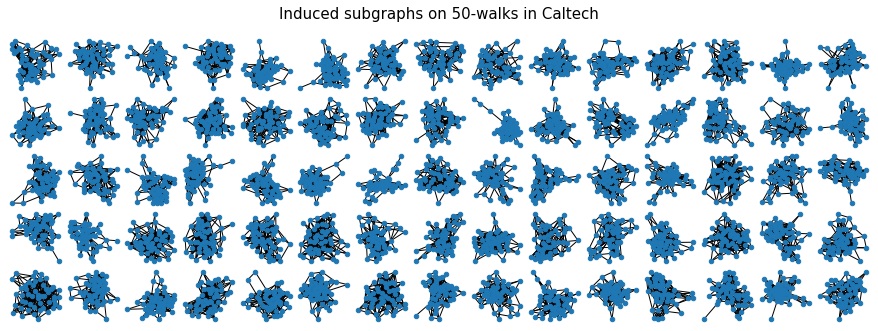

In [3]:
X, embs = G.get_patches(k=k, sample_size=1600, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 1600


In [65]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 0.35

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

0    1    2    3    4    5    6    7    8    9  ...  2491  2492  2493  \
0     0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   1.0   1.0   0.0   
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   1.0   
3     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
1595  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1596  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
1597  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1598  0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
1599  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

      2494  2495  2496  2497  2498  2499  Synchronized  
0      0.0   0.0   0.0   0.0   1.0   0.0          True  
1      0.0   0.0   0.0   1.0   1.0   0.0         False  
2      1.0   0.0   1.0   1.0   1.0   0.0         False  
3      0.0   0.0   0.0   0.0   1.0   0.0         False  
4      0.0   0.0   0.0   0.0   1.0   0.0         False  
...    ...   ...   ...   ...   ...   ...           ...  
1595   0.0   0.0   0.0   0.0   1.0   0.0          True  
1596   0.0   0.0   0.0   0.0   1.0   0.0          True  
1597   1.0   1.0   1.0   0.0   1.0   0.0         False  
1598   0.0   0.0   0.0   0.0   1.0   0.0         False  
1599   0.0   0.0   0.0   0.0   1.0   0.0         False  

[1600 rows x 2501 columns]

In [66]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.346875


In [67]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [68]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  2%|█                                          | 6/250 [00:00<00:04, 58.44it/s]

iteration 0, reconstruction error 267000.031146
iteration 10, reconstruction error 184468.814143


 14%|█████▉                                    | 35/250 [00:00<00:02, 92.77it/s]

iteration 20, reconstruction error 182404.165484
iteration 30, reconstruction error 174783.663457
iteration 40, reconstruction error 169638.957380


 26%|███████████                               | 66/250 [00:00<00:01, 96.36it/s]

iteration 50, reconstruction error 168468.023100
iteration 60, reconstruction error 168006.151518
iteration 70, reconstruction error 167764.725030


 38%|████████████████▏                         | 96/250 [00:01<00:01, 93.97it/s]

iteration 80, reconstruction error 167610.151633
iteration 90, reconstruction error 167500.236406


 46%|██████████████████▊                      | 115/250 [00:01<00:01, 84.66it/s]

iteration 100, reconstruction error 167416.323238
iteration 110, reconstruction error 167349.920573


 54%|█████████████████████▉                   | 134/250 [00:01<00:01, 87.98it/s]

iteration 120, reconstruction error 167294.826918
iteration 130, reconstruction error 167247.809458


 61%|████████████████████████▉                | 152/250 [00:01<00:01, 87.39it/s]

iteration 140, reconstruction error 167206.538080
iteration 150, reconstruction error 167169.750628


 69%|████████████████████████████▏            | 172/250 [00:01<00:00, 91.34it/s]

iteration 160, reconstruction error 167136.513661
iteration 170, reconstruction error 167106.098195


 77%|███████████████████████████████▋         | 193/250 [00:02<00:00, 94.72it/s]

iteration 180, reconstruction error 167078.089102
iteration 190, reconstruction error 167052.191880
iteration 200, reconstruction error 167028.437450


 90%|████████████████████████████████████▋    | 224/250 [00:02<00:00, 96.77it/s]

iteration 210, reconstruction error 167006.579562
iteration 220, reconstruction error 166986.333178
iteration 230, reconstruction error 166967.389984


100%|█████████████████████████████████████████| 250/250 [00:02<00:00, 92.00it/s]


iteration 240, reconstruction error 166949.492943


###########################
Shape of W_true: (2500, 9)
###########################




  2%|█                                          | 6/250 [00:00<00:04, 53.02it/s]

iteration 0, reconstruction error 488443.239401


  7%|███                                       | 18/250 [00:00<00:04, 48.83it/s]

iteration 10, reconstruction error 338054.708482
iteration 20, reconstruction error 336628.339769


 15%|██████▍                                   | 38/250 [00:00<00:04, 48.65it/s]

iteration 30, reconstruction error 330780.936641


 20%|████████▍                                 | 50/250 [00:01<00:03, 50.98it/s]

iteration 40, reconstruction error 317212.038660
iteration 50, reconstruction error 311960.575439


 27%|███████████▍                              | 68/250 [00:01<00:03, 50.22it/s]

iteration 60, reconstruction error 310566.323021


 32%|█████████████▍                            | 80/250 [00:01<00:03, 51.04it/s]

iteration 70, reconstruction error 309980.231688
iteration 80, reconstruction error 309672.326643


 39%|████████████████▎                         | 97/250 [00:01<00:03, 49.54it/s]

iteration 90, reconstruction error 309476.375374


 43%|█████████████████▋                       | 108/250 [00:02<00:02, 50.24it/s]

iteration 100, reconstruction error 309336.860958


 48%|███████████████████▋                     | 120/250 [00:02<00:02, 51.52it/s]

iteration 110, reconstruction error 309230.551972
iteration 120, reconstruction error 309145.087283


 55%|██████████████████████▋                  | 138/250 [00:02<00:02, 51.40it/s]

iteration 130, reconstruction error 309073.247889
iteration 140, reconstruction error 309011.293754


 62%|█████████████████████████▌               | 156/250 [00:03<00:01, 50.24it/s]

iteration 150, reconstruction error 308956.581856
iteration 160, reconstruction error 308907.515036


 72%|█████████████████████████████▌           | 180/250 [00:03<00:01, 51.64it/s]

iteration 170, reconstruction error 308863.180029
iteration 180, reconstruction error 308822.796616


 79%|████████████████████████████████▍        | 198/250 [00:03<00:01, 50.06it/s]

iteration 190, reconstruction error 308785.707673


 84%|██████████████████████████████████▍      | 210/250 [00:04<00:00, 52.11it/s]

iteration 200, reconstruction error 308751.542265
iteration 210, reconstruction error 308719.959205


 91%|█████████████████████████████████████▍   | 228/250 [00:04<00:00, 49.59it/s]

iteration 220, reconstruction error 308690.698730


 96%|███████████████████████████████████████▏ | 239/250 [00:04<00:00, 50.95it/s]

iteration 230, reconstruction error 308663.494181
iteration 240, reconstruction error 308638.121972


100%|█████████████████████████████████████████| 250/250 [00:04<00:00, 50.18it/s]



###########################
Shape of W_false: (2500, 9)
###########################




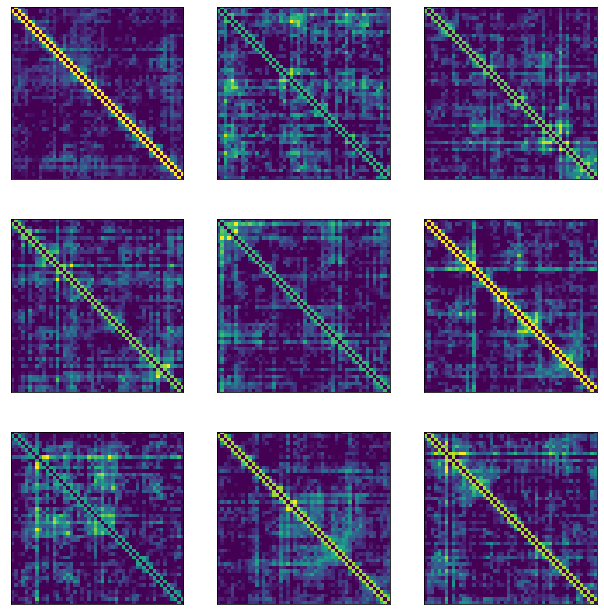

In [69]:
display_dictionary(W = W_true,
                   figsize = [10,10])

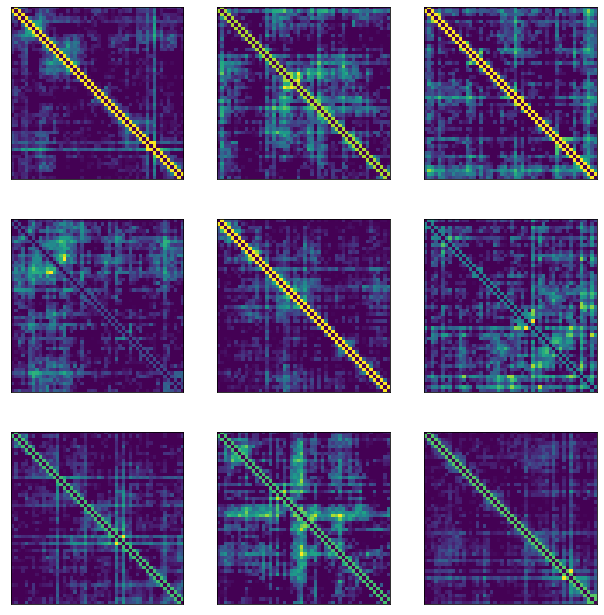

In [70]:
display_dictionary(W = W_false,
                   figsize = [10,10])

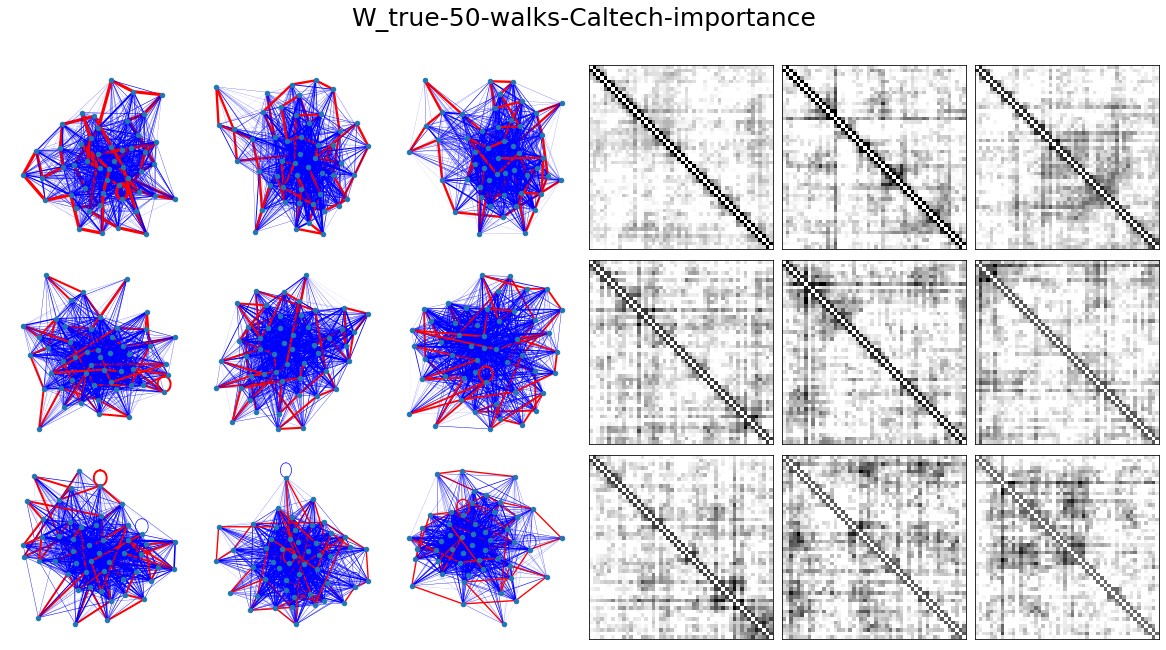

In [71]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

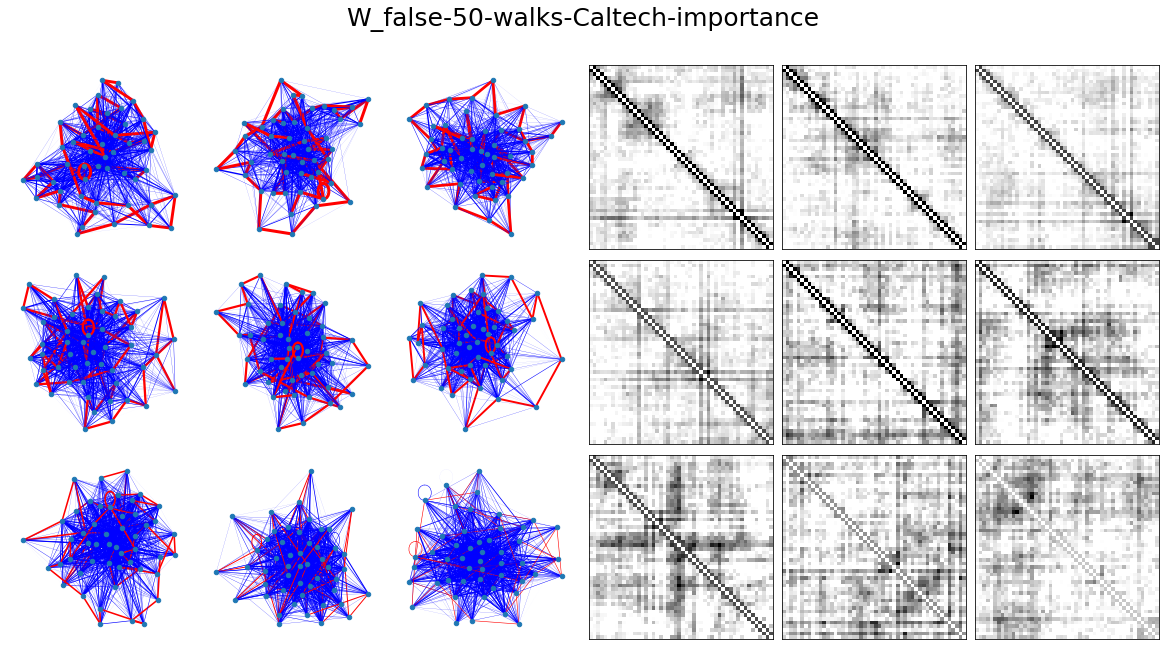

In [72]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

In [73]:
true_norm = np.linalg.norm(W_true.T, ord=1, axis=1)
false_norm = np.linalg.norm(W_false.T, ord=1, axis=1)

data_arr = np.stack((true_norm, false_norm), axis=0).T
df_boxplot = pd.DataFrame(data_arr, columns = ['Synchronizing','Non-Synchronizing'])
df_boxplot

Synchronizing  Non-Synchronizing
0      10.126187           9.720833
1      10.760462          10.219658
2      10.087141          10.504015
3      10.644825           9.679061
4      10.457053           9.420549
5       9.826043          10.263782
6       9.787902          10.167663
7      10.870003          10.240098
8      10.526638          10.006464

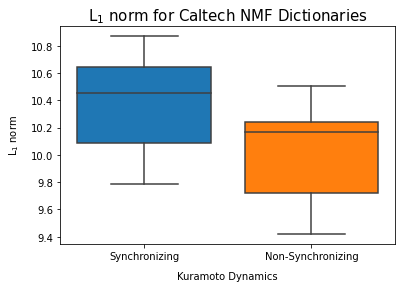

In [74]:
ax = sns.boxplot(data=df_boxplot, saturation=1)
ax.axes.set_title("L$_1$ norm for Caltech NMF Dictionaries", fontsize=15)
plt.xlabel("Kuramoto Dynamics", labelpad=10)
plt.ylabel("L$_1$ norm", labelpad=10);

In [13]:
X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = 0.25,
                                                    stratify = Y)

In [14]:
# SDL_BCD_feature
data_scale=10
results_dict_list = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                X_test = [X_test.T/data_scale, Y_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new = SDL_BCD_class.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[-0.15974855  0.80931178 -0.52757944  0.30196793  0.90898696 -0.3452638
  -0.84825891  0.86444745 -0.82907735 -0.20973236  0.62892367  0.45828045
   0.65236074  0.17168081  0.20152893  0.44598024  0.18457291]]


  0%|▏                                          | 1/200 [00:00<00:28,  7.04it/s]

--- Training --- [threshold, AUC] =  [0.617, 0.588]
--- Iteration 0: Training loss --- [Data, Label, Total] = [656.212907.3, 1249.199025.3, 1249.199025.3]


  8%|███▎                                      | 16/200 [00:00<00:08, 21.80it/s]

--- Training --- [threshold, AUC] =  [0.705, 0.592]
--- Iteration 10: Training loss --- [Data, Label, Total] = [972.742354.3, 1283.179259.3, 1283.179259.3]


 12%|█████▎                                    | 25/200 [00:01<00:08, 20.23it/s]

--- Training --- [threshold, AUC] =  [0.766, 0.57]
--- Iteration 20: Training loss --- [Data, Label, Total] = [975.308705.3, 1354.276846.3, 1354.276846.3]


 17%|███████▏                                  | 34/200 [00:01<00:08, 19.96it/s]

--- Training --- [threshold, AUC] =  [0.789, 0.562]
--- Iteration 30: Training loss --- [Data, Label, Total] = [977.075932.3, 1395.271862.3, 1395.271862.3]


 23%|█████████▋                                | 46/200 [00:02<00:07, 20.98it/s]

--- Training --- [threshold, AUC] =  [0.8, 0.569]
--- Iteration 40: Training loss --- [Data, Label, Total] = [978.538725.3, 1417.172018.3, 1417.172018.3]


 28%|███████████▌                              | 55/200 [00:02<00:06, 21.56it/s]

--- Training --- [threshold, AUC] =  [0.807, 0.575]
--- Iteration 50: Training loss --- [Data, Label, Total] = [980.249190.3, 1433.511323.3, 1433.511323.3]


 32%|█████████████▍                            | 64/200 [00:03<00:06, 21.93it/s]

--- Training --- [threshold, AUC] =  [0.812, 0.576]
--- Iteration 60: Training loss --- [Data, Label, Total] = [981.197938.3, 1446.165139.3, 1446.165139.3]


 38%|███████████████▉                          | 76/200 [00:03<00:05, 22.40it/s]

--- Training --- [threshold, AUC] =  [0.818, 0.578]
--- Iteration 70: Training loss --- [Data, Label, Total] = [982.508918.3, 1460.307790.3, 1460.307790.3]


 42%|█████████████████▊                        | 85/200 [00:03<00:04, 23.40it/s]

--- Training --- [threshold, AUC] =  [0.824, 0.58]
--- Iteration 80: Training loss --- [Data, Label, Total] = [983.499071.3, 1475.468078.3, 1475.468078.3]


 47%|███████████████████▋                      | 94/200 [00:04<00:04, 23.88it/s]

--- Training --- [threshold, AUC] =  [0.828, 0.582]
--- Iteration 90: Training loss --- [Data, Label, Total] = [984.299423.3, 1485.716345.3, 1485.716345.3]


 54%|█████████████████████▉                   | 107/200 [00:04<00:03, 26.09it/s]

--- Training --- [threshold, AUC] =  [0.831, 0.586]
--- Iteration 100: Training loss --- [Data, Label, Total] = [985.062367.3, 1494.374219.3, 1494.374219.3]


 58%|███████████████████████▉                 | 117/200 [00:05<00:03, 26.62it/s]

--- Training --- [threshold, AUC] =  [0.834, 0.589]
--- Iteration 110: Training loss --- [Data, Label, Total] = [985.897915.3, 1504.656439.3, 1504.656439.3]


 63%|█████████████████████████▊               | 126/200 [00:05<00:02, 25.22it/s]

--- Training --- [threshold, AUC] =  [0.837, 0.59]
--- Iteration 120: Training loss --- [Data, Label, Total] = [986.545098.3, 1513.592417.3, 1513.592417.3]


 68%|███████████████████████████▋             | 135/200 [00:05<00:02, 25.18it/s]

--- Training --- [threshold, AUC] =  [0.84, 0.592]
--- Iteration 130: Training loss --- [Data, Label, Total] = [987.218063.3, 1522.296951.3, 1522.296951.3]


 72%|█████████████████████████████▋           | 145/200 [00:06<00:02, 25.60it/s]

--- Training --- [threshold, AUC] =  [0.842, 0.594]
--- Iteration 140: Training loss --- [Data, Label, Total] = [987.882770.3, 1529.035158.3, 1529.035158.3]


 78%|███████████████████████████████▊         | 155/200 [00:06<00:01, 26.11it/s]

--- Training --- [threshold, AUC] =  [0.845, 0.596]
--- Iteration 150: Training loss --- [Data, Label, Total] = [988.577250.3, 1538.637826.3, 1538.637826.3]


 82%|█████████████████████████████████▊       | 165/200 [00:07<00:01, 26.85it/s]

--- Training --- [threshold, AUC] =  [0.847, 0.597]
--- Iteration 160: Training loss --- [Data, Label, Total] = [989.152884.3, 1546.354792.3, 1546.354792.3]


 87%|███████████████████████████████████▋     | 174/200 [00:07<00:01, 24.86it/s]

--- Training --- [threshold, AUC] =  [0.85, 0.6]
--- Iteration 170: Training loss --- [Data, Label, Total] = [989.783572.3, 1554.225720.3, 1554.225720.3]


 92%|█████████████████████████████████████▋   | 184/200 [00:07<00:00, 25.50it/s]

--- Training --- [threshold, AUC] =  [0.852, 0.601]
--- Iteration 180: Training loss --- [Data, Label, Total] = [990.437818.3, 1561.988778.3, 1561.988778.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:08<00:00, 25.60it/s]

--- Training --- [threshold, AUC] =  [0.853, 0.604]
--- Iteration 190: Training loss --- [Data, Label, Total] = [990.940646.3, 1567.064207.3, 1567.064207.3]


100%|█████████████████████████████████████████| 200/200 [00:08<00:00, 23.49it/s]


!!! pred_type naive
initial loading beta [[ 0.88113415 -0.20075408  0.87361357  0.43945894  0.68385747 -0.37928791
   0.25071658  0.50989975  0.12820161 -0.35922683 -0.23688606  0.69617321
  -0.33803089  0.04864446  0.59159022  0.37259837  0.09385754]]


  2%|▊                                          | 4/200 [00:00<00:09, 19.93it/s]

--- Training --- [threshold, AUC] =  [0.679, 0.587]
--- Iteration 0: Training loss --- [Data, Label, Total] = [667.204882.3, 1266.179184.3, 1266.179184.3]


  5%|██                                        | 10/200 [00:00<00:10, 18.96it/s]


--- Training --- [threshold, AUC] =  [0.998, 0.622]
--- Iteration 10: Training loss --- [Data, Label, Total] = [987.457607.3, 4587.747988.3, 4587.747988.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.2971999  -0.41602469 -0.75822016 -0.36173081 -0.38315323  0.92736761
  -0.26827009 -0.30975763  0.4771163  -0.8116657   0.15792198  0.60898249
   0.63859685  0.07050522  0.4127586  -0.50306093  0.20741384]]


  2%|▊                                          | 4/200 [00:00<00:09, 20.82it/s]

--- Training --- [threshold, AUC] =  [0.618, 0.586]
--- Iteration 0: Training loss --- [Data, Label, Total] = [627.435312.3, 1249.196813.3, 1311.940345.3]


  5%|██                                        | 10/200 [00:00<00:09, 19.46it/s]


--- Training --- [threshold, AUC] =  [0.958, 0.71]
--- Iteration 10: Training loss --- [Data, Label, Total] = [877.304391.3, 2329.832085.3, 2417.562524.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.33722859  0.30789155 -0.05797938  0.68441549 -0.07229396  0.70252253
   0.80720993  0.12179574  0.35708367  0.52197559  0.54679055  0.13626175
   0.89389527  0.74374196 -0.77965797  0.98183303 -0.26728021]]


  2%|█                                          | 5/200 [00:00<00:08, 23.06it/s]

--- Training --- [threshold, AUC] =  [0.724, 0.414]
--- Iteration 0: Training loss --- [Data, Label, Total] = [650.661454.3, 1301.178304.3, 1366.244449.3]


  5%|██                                        | 10/200 [00:00<00:09, 20.01it/s]


--- Training --- [threshold, AUC] =  [1.0, 0.422]
--- Iteration 10: Training loss --- [Data, Label, Total] = [934.146135.3, 10976.777803.3, 11070.192417.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.0068165  -0.52218657 -0.22626587 -0.13733396  0.27376154  0.06103848
   0.94900324 -0.39266605  0.56493768  0.1159257  -0.63313231 -0.78662774
   0.46006407 -0.13495182 -0.07807753 -0.83958623  0.01011639]]


  0%|▏                                          | 1/200 [00:00<00:20,  9.73it/s]

--- Training --- [threshold, AUC] =  [0.56, 0.413]
--- Iteration 0: Training loss --- [Data, Label, Total] = [612.274242.3, 1261.079925.3, 1873.354167.3]


  5%|██                                        | 10/200 [00:00<00:09, 20.12it/s]


--- Training --- [threshold, AUC] =  [0.083, 0.598]
--- Iteration 10: Training loss --- [Data, Label, Total] = [531.766115.3, 2930.474589.3, 3462.240704.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.47926439 -0.0283224   0.28524059 -0.60408806  0.65882519 -0.25910666
  -0.80248308  0.6414782  -0.11762796  0.11074685 -0.83220459  0.67731313
   0.27401955 -0.90118103 -0.4979743  -0.12245846  0.39819799]]


  0%|▏                                          | 1/200 [00:00<00:20,  9.83it/s]

--- Training --- [threshold, AUC] =  [0.756, 0.586]
--- Iteration 0: Training loss --- [Data, Label, Total] = [595.995954.3, 1340.452622.3, 1936.448576.3]


  5%|██                                        | 10/200 [00:00<00:10, 17.46it/s]


--- Training --- [threshold, AUC] =  [1.0, 0.437]
--- Iteration 10: Training loss --- [Data, Label, Total] = [527.205257.3, 10801.170010.3, 11328.375267.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.85290147 -0.77680657  0.52668584  0.22816708 -0.91120239  0.85857335
  -0.364267   -0.07165256 -0.28744952 -0.94278135 -0.66267442  0.96466648
   0.27177979 -0.66066009 -0.79007445  0.30869013 -0.88355962]]


  2%|▊                                          | 4/200 [00:00<00:10, 18.11it/s]

--- Training --- [threshold, AUC] =  [0.733, 0.585]
--- Iteration 0: Training loss --- [Data, Label, Total] = [536.406176.3, 1310.865238.3, 3992.896117.3]


  5%|██                                        | 10/200 [00:00<00:10, 18.29it/s]


--- Training --- [threshold, AUC] =  [1.0, 0.425]
--- Iteration 10: Training loss --- [Data, Label, Total] = [283.062939.3, 9403.628154.3, 10818.942847.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.1609021   0.56279088 -0.31245419 -0.34821904 -0.16538254  0.22582504
   0.25587894  0.75256636  0.28974866  0.50565644  0.19854708 -0.18830978
   0.59441312 -0.38553687  0.73623151 -0.08244719  0.24822058]]


  0%|▏                                          | 1/200 [00:00<00:20,  9.70it/s]

--- Training --- [threshold, AUC] =  [0.592, 0.586]
--- Iteration 0: Training loss --- [Data, Label, Total] = [533.779839.3, 1251.357759.3, 3920.256955.3]


  8%|███▎                                      | 16/200 [00:00<00:06, 26.65it/s]

--- Training --- [threshold, AUC] =  [0.599, 0.61]
--- Iteration 10: Training loss --- [Data, Label, Total] = [263.617422.3, 1249.852321.3, 2567.939428.3]


 12%|█████▎                                    | 25/200 [00:01<00:07, 24.83it/s]

--- Training --- [threshold, AUC] =  [0.822, 0.68]
--- Iteration 20: Training loss --- [Data, Label, Total] = [148.530366.3, 1471.176611.3, 2213.828443.3]


 17%|███████▏                                  | 34/200 [00:01<00:06, 24.60it/s]

--- Training --- [threshold, AUC] =  [0.838, 0.581]
--- Iteration 30: Training loss --- [Data, Label, Total] = [104.061462.3, 1515.978737.3, 2036.286045.3]


 22%|█████████▍                                | 45/200 [00:01<00:05, 25.91it/s]

--- Training --- [threshold, AUC] =  [0.832, 0.524]
--- Iteration 40: Training loss --- [Data, Label, Total] = [12.778742.3, 1499.496952.3, 1563.390660.3]


 27%|███████████▎                              | 54/200 [00:02<00:05, 25.36it/s]

--- Training --- [threshold, AUC] =  [0.837, 0.799]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.840551.3, 1514.349825.3, 1528.552582.3]


 32%|█████████████▋                            | 65/200 [00:02<00:05, 26.06it/s]

--- Training --- [threshold, AUC] =  [0.843, 0.787]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.433720.3, 1530.520984.3, 1542.689583.3]


 37%|███████████████▌                          | 74/200 [00:02<00:05, 25.20it/s]

--- Training --- [threshold, AUC] =  [0.847, 0.783]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.347645.3, 1544.283736.3, 1556.021963.3]


 42%|█████████████████▋                        | 84/200 [00:03<00:04, 25.48it/s]

--- Training --- [threshold, AUC] =  [0.853, 0.788]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.336089.3, 1567.300762.3, 1578.981209.3]


 47%|███████████████████▋                      | 94/200 [00:03<00:04, 25.48it/s]

--- Training --- [threshold, AUC] =  [0.857, 0.788]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.332207.3, 1580.378258.3, 1592.039295.3]


 52%|█████████████████████▎                   | 104/200 [00:04<00:04, 22.57it/s]

--- Training --- [threshold, AUC] =  [0.86, 0.788]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.330675.3, 1593.030377.3, 1604.683752.3]


 57%|███████████████████████▌                 | 115/200 [00:04<00:03, 25.53it/s]

--- Training --- [threshold, AUC] =  [0.864, 0.788]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.329890.3, 1606.109873.3, 1617.759321.3]


 62%|█████████████████████████▍               | 124/200 [00:05<00:03, 24.06it/s]

--- Training --- [threshold, AUC] =  [0.867, 0.789]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.329554.3, 1617.436060.3, 1629.083831.3]


 67%|███████████████████████████▍             | 134/200 [00:05<00:02, 24.73it/s]

--- Training --- [threshold, AUC] =  [0.87, 0.788]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.329374.3, 1630.630961.3, 1642.277830.3]


 73%|█████████████████████████████▉           | 146/200 [00:05<00:02, 25.36it/s]

--- Training --- [threshold, AUC] =  [0.872, 0.788]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.329258.3, 1638.166943.3, 1649.813233.3]


 78%|███████████████████████████████▉         | 156/200 [00:06<00:01, 25.85it/s]

--- Training --- [threshold, AUC] =  [0.874, 0.788]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.329174.3, 1648.493473.3, 1660.139346.3]


 83%|██████████████████████████████████       | 166/200 [00:06<00:01, 25.82it/s]

--- Training --- [threshold, AUC] =  [0.876, 0.788]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.329123.3, 1658.886666.3, 1670.532282.3]


 88%|███████████████████████████████████▉     | 175/200 [00:07<00:00, 25.07it/s]

--- Training --- [threshold, AUC] =  [0.879, 0.788]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.329077.3, 1669.511977.3, 1681.157364.3]


 92%|█████████████████████████████████████▋   | 184/200 [00:07<00:00, 24.58it/s]

--- Training --- [threshold, AUC] =  [0.88, 0.787]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.329035.3, 1677.870922.3, 1689.516096.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:07<00:00, 25.06it/s]

--- Training --- [threshold, AUC] =  [0.883, 0.787]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.328995.3, 1688.879339.3, 1700.524315.3]


100%|█████████████████████████████████████████| 200/200 [00:08<00:00, 24.92it/s]


!!! pred_type naive
initial loading beta [[-0.28681457 -0.68389578  0.52837275  0.0297173  -0.03223094  0.22786178
   0.20898874 -0.9734404  -0.95048211 -0.71017494 -0.60090601  0.92049699
   0.41426917 -0.01786111  0.1695974   0.66812277  0.07952151]]


  2%|█                                          | 5/200 [00:00<00:07, 24.48it/s]

--- Training --- [threshold, AUC] =  [1.571, 0.438]
--- Iteration 0: Training loss --- [Data, Label, Total] = [527.017446.3, 1256.818151.3, 6526.992610.3]


  7%|██▉                                       | 14/200 [00:00<00:08, 21.89it/s]

--- Training --- [threshold, AUC] =  [0.141, 0.636]
--- Iteration 10: Training loss --- [Data, Label, Total] = [250.260856.3, 2373.541404.3, 4876.149968.3]


 13%|█████▍                                    | 26/200 [00:01<00:08, 21.09it/s]

--- Training --- [threshold, AUC] =  [0.109, 0.553]
--- Iteration 20: Training loss --- [Data, Label, Total] = [124.457705.3, 2645.804273.3, 3890.381327.3]


 18%|███████▎                                  | 35/200 [00:01<00:07, 22.88it/s]

--- Training --- [threshold, AUC] =  [0.095, 0.662]
--- Iteration 30: Training loss --- [Data, Label, Total] = [37.830231.3, 2786.694363.3, 3164.996677.3]


 22%|█████████▏                                | 44/200 [00:02<00:06, 23.26it/s]

--- Training --- [threshold, AUC] =  [0.118, 0.769]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.681357.3, 2560.702740.3, 2587.516314.3]


 28%|███████████▊                              | 56/200 [00:02<00:05, 24.20it/s]

--- Training --- [threshold, AUC] =  [0.135, 0.783]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.473994.3, 2411.859825.3, 2436.599762.3]


 33%|█████████████▊                            | 66/200 [00:02<00:05, 25.50it/s]

--- Training --- [threshold, AUC] =  [0.147, 0.763]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.344311.3, 2325.145978.3, 2348.589087.3]


 38%|███████████████▊                          | 75/200 [00:03<00:05, 24.80it/s]

--- Training --- [threshold, AUC] =  [0.159, 0.78]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.334135.3, 2245.982877.3, 2269.324223.3]


 42%|█████████████████▊                        | 85/200 [00:03<00:04, 26.03it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.79]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.330615.3, 2179.104467.3, 2202.410622.3]


 47%|███████████████████▋                      | 94/200 [00:04<00:04, 25.17it/s]

--- Training --- [threshold, AUC] =  [0.18, 0.796]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.329266.3, 2122.795965.3, 2146.088620.3]


 52%|█████████████████████▎                   | 104/200 [00:04<00:03, 25.39it/s]

--- Training --- [threshold, AUC] =  [0.189, 0.798]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.328785.3, 2074.695858.3, 2097.983710.3]


 57%|███████████████████████▎                 | 114/200 [00:04<00:03, 24.87it/s]

--- Training --- [threshold, AUC] =  [0.198, 0.8]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.328578.3, 2029.310690.3, 2052.596471.3]


 62%|█████████████████████████▋               | 125/200 [00:05<00:02, 26.60it/s]

--- Training --- [threshold, AUC] =  [0.206, 0.801]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.328446.3, 1988.978581.3, 2012.263046.3]


 68%|███████████████████████████▋             | 135/200 [00:05<00:02, 27.06it/s]

--- Training --- [threshold, AUC] =  [0.214, 0.801]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.328355.3, 1950.948628.3, 1974.232179.3]


 73%|█████████████████████████████▉           | 146/200 [00:06<00:01, 27.36it/s]

--- Training --- [threshold, AUC] =  [0.223, 0.801]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.328278.3, 1914.680815.3, 1937.963592.3]


 78%|███████████████████████████████▉         | 156/200 [00:06<00:01, 26.06it/s]

--- Training --- [threshold, AUC] =  [0.229, 0.802]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.328226.3, 1887.108891.3, 1910.391146.3]


 82%|█████████████████████████████████▊       | 165/200 [00:06<00:01, 24.72it/s]

--- Training --- [threshold, AUC] =  [0.236, 0.802]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.328175.3, 1860.426429.3, 1883.708178.3]


 87%|███████████████████████████████████▋     | 174/200 [00:07<00:01, 24.39it/s]

--- Training --- [threshold, AUC] =  [0.243, 0.802]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.328128.3, 1834.974639.3, 1858.255916.3]


 92%|█████████████████████████████████████▉   | 185/200 [00:07<00:00, 26.20it/s]

--- Training --- [threshold, AUC] =  [0.249, 0.803]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.328075.3, 1809.326448.3, 1832.607194.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:07<00:00, 25.32it/s]

--- Training --- [threshold, AUC] =  [0.256, 0.803]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.328027.3, 1784.544301.3, 1807.824567.3]


100%|█████████████████████████████████████████| 200/200 [00:08<00:00, 24.28it/s]


!!! pred_type naive
initial loading beta [[-0.90132674 -0.02762783 -0.57379651  0.57206677  0.88994887  0.9223441
   0.58422698 -0.29727217 -0.82542771  0.64413903 -0.67737014 -0.79923962
   0.74859673  0.36469106 -0.68678916 -0.77611485 -0.65287291]]


  2%|▊                                          | 4/200 [00:00<00:11, 17.79it/s]

--- Training --- [threshold, AUC] =  [0.607, 0.585]
--- Iteration 0: Training loss --- [Data, Label, Total] = [538.610038.3, 1249.423447.3, 6635.523831.3]


  7%|██▉                                       | 14/200 [00:00<00:08, 20.77it/s]

--- Training --- [threshold, AUC] =  [0.959, 0.542]
--- Iteration 10: Training loss --- [Data, Label, Total] = [257.429998.3, 2352.169372.3, 4926.469352.3]


 13%|█████▍                                    | 26/200 [00:01<00:08, 21.37it/s]

--- Training --- [threshold, AUC] =  [0.927, 0.577]
--- Iteration 20: Training loss --- [Data, Label, Total] = [145.477962.3, 1978.754401.3, 3433.534021.3]


 18%|███████▌                                  | 36/200 [00:01<00:07, 22.36it/s]

--- Training --- [threshold, AUC] =  [0.926, 0.492]
--- Iteration 30: Training loss --- [Data, Label, Total] = [35.236609.3, 1961.935686.3, 2314.301780.3]


 22%|█████████▍                                | 45/200 [00:02<00:07, 21.58it/s]

--- Training --- [threshold, AUC] =  [0.926, 0.775]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.432641.3, 1965.362302.3, 1989.688714.3]


 27%|███████████▎                              | 54/200 [00:02<00:06, 23.09it/s]

--- Training --- [threshold, AUC] =  [0.929, 0.785]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.348673.3, 1989.463820.3, 2012.950546.3]


 33%|█████████████▊                            | 66/200 [00:03<00:06, 22.12it/s]

--- Training --- [threshold, AUC] =  [0.931, 0.787]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.336751.3, 2013.882937.3, 2037.250452.3]


 38%|███████████████▉                          | 76/200 [00:03<00:05, 24.22it/s]

--- Training --- [threshold, AUC] =  [0.934, 0.786]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.331895.3, 2033.740202.3, 2057.059155.3]


 44%|██████████████████▎                       | 87/200 [00:03<00:04, 26.52it/s]

--- Training --- [threshold, AUC] =  [0.935, 0.788]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.330203.3, 2048.862483.3, 2072.164508.3]


 48%|████████████████████▏                     | 96/200 [00:04<00:04, 25.29it/s]

--- Training --- [threshold, AUC] =  [0.937, 0.788]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.329564.3, 2066.216990.3, 2089.512629.3]


 53%|█████████████████████▋                   | 106/200 [00:04<00:03, 25.99it/s]

--- Training --- [threshold, AUC] =  [0.938, 0.789]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.329287.3, 2075.416734.3, 2098.709601.3]


 58%|███████████████████████▊                 | 116/200 [00:05<00:03, 26.09it/s]

--- Training --- [threshold, AUC] =  [0.939, 0.788]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.329112.3, 2090.920429.3, 2114.211546.3]


 62%|█████████████████████████▋               | 125/200 [00:05<00:02, 25.38it/s]

--- Training --- [threshold, AUC] =  [0.94, 0.788]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.329023.3, 2103.551442.3, 2126.841671.3]


 68%|███████████████████████████▋             | 135/200 [00:05<00:02, 26.28it/s]

--- Training --- [threshold, AUC] =  [0.941, 0.788]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.328953.3, 2115.903292.3, 2139.192817.3]


 72%|█████████████████████████████▌           | 144/200 [00:06<00:02, 25.05it/s]

--- Training --- [threshold, AUC] =  [0.942, 0.788]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.328899.3, 2124.687578.3, 2147.976568.3]


 78%|███████████████████████████████▊         | 155/200 [00:06<00:01, 25.89it/s]

--- Training --- [threshold, AUC] =  [0.943, 0.788]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.328873.3, 2132.489981.3, 2155.778706.3]


 82%|█████████████████████████████████▊       | 165/200 [00:06<00:01, 26.41it/s]

--- Training --- [threshold, AUC] =  [0.943, 0.788]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.328835.3, 2138.018486.3, 2161.306839.3]


 88%|███████████████████████████████████▉     | 175/200 [00:07<00:00, 25.55it/s]

--- Training --- [threshold, AUC] =  [0.944, 0.787]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.328803.3, 2148.547691.3, 2171.835724.3]


 92%|█████████████████████████████████████▉   | 185/200 [00:07<00:00, 26.63it/s]

--- Training --- [threshold, AUC] =  [0.945, 0.787]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.328777.3, 2155.499460.3, 2178.787227.3]


 98%|███████████████████████████████████████▉ | 195/200 [00:08<00:00, 25.65it/s]

--- Training --- [threshold, AUC] =  [0.945, 0.786]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.328746.3, 2161.923834.3, 2185.211294.3]


100%|█████████████████████████████████████████| 200/200 [00:08<00:00, 23.94it/s]


!!! pred_type naive


In [15]:
W = results_dict_new['loading'][0]
coeff = results_dict_new['loading'][1][0]
H = results_dict_new['code']

In [16]:
coeff

array([4.63382974e-01, 6.38797917e-03, 2.81083018e-01, 5.33076523e-03,
       3.44936381e-03, 1.28990276e-03, 8.34283445e-04, 5.50851900e-04,
       1.14476293e-03, 8.24508964e-04, 3.91447138e-04, 8.39969144e-04,
       1.46994163e-04, 8.96427157e-04, 8.33559110e-04, 1.98130641e-03,
       4.44695597e-03])

In [17]:
print('Accuracy: {}'.format(results_dict_new['Accuracy']))
print('Training RRE: {}'.format(results_dict_new['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new['Relative_reconstruction_loss (test)']))

Accuracy: 0.5376
Training RRE: 0.651330425780358
Testing RRE: 0.8229699357826572


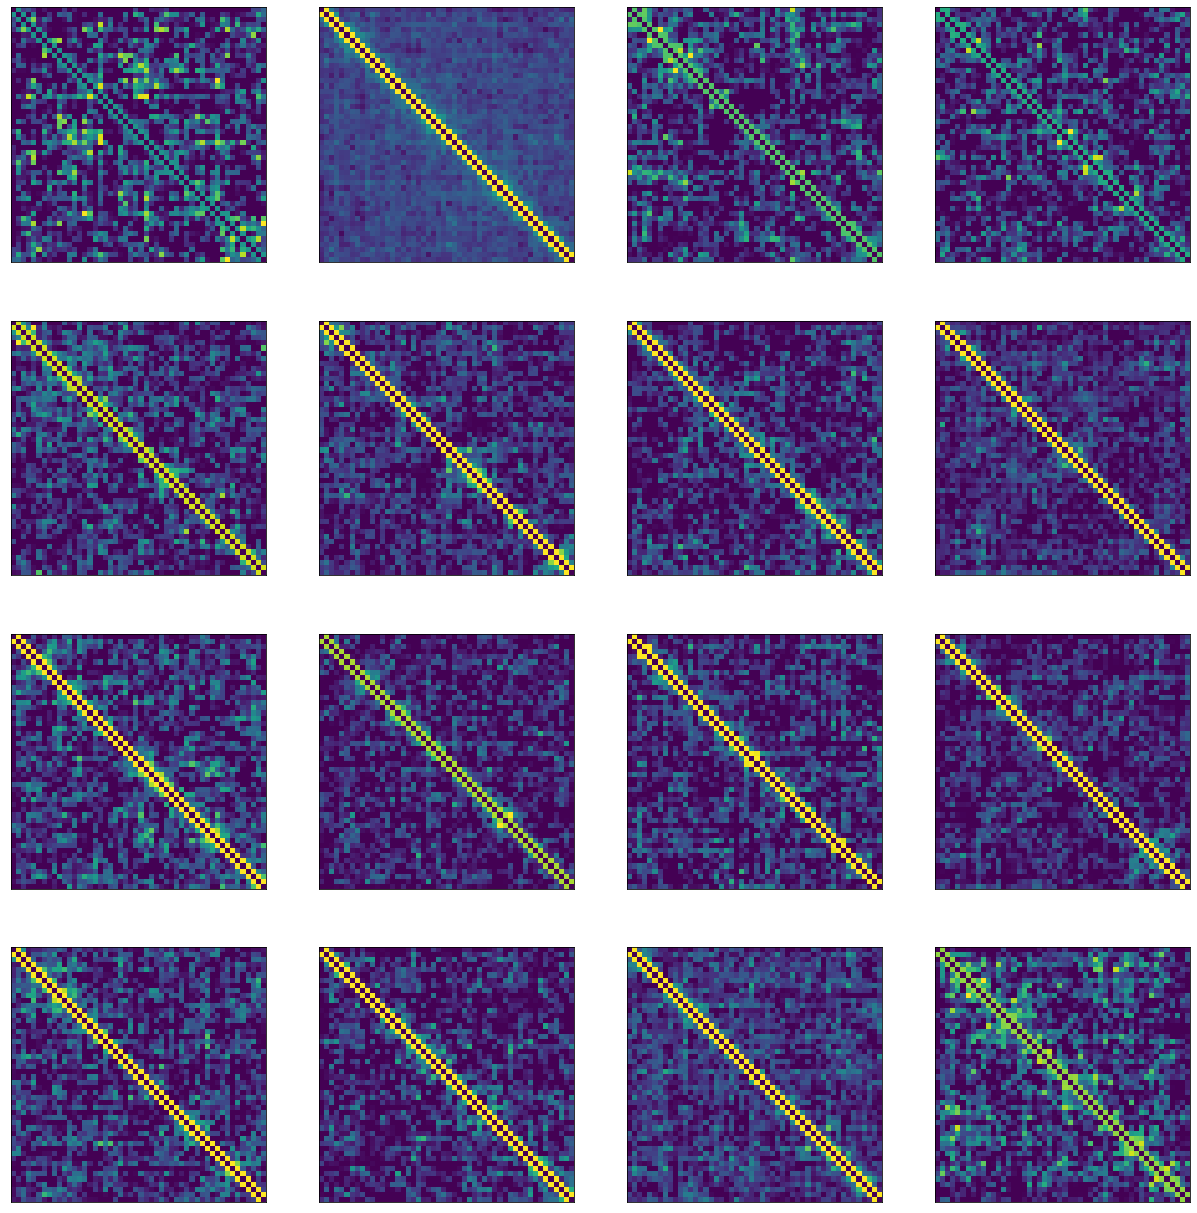

In [18]:
display_dictionary(W = W, figsize=[20,20])

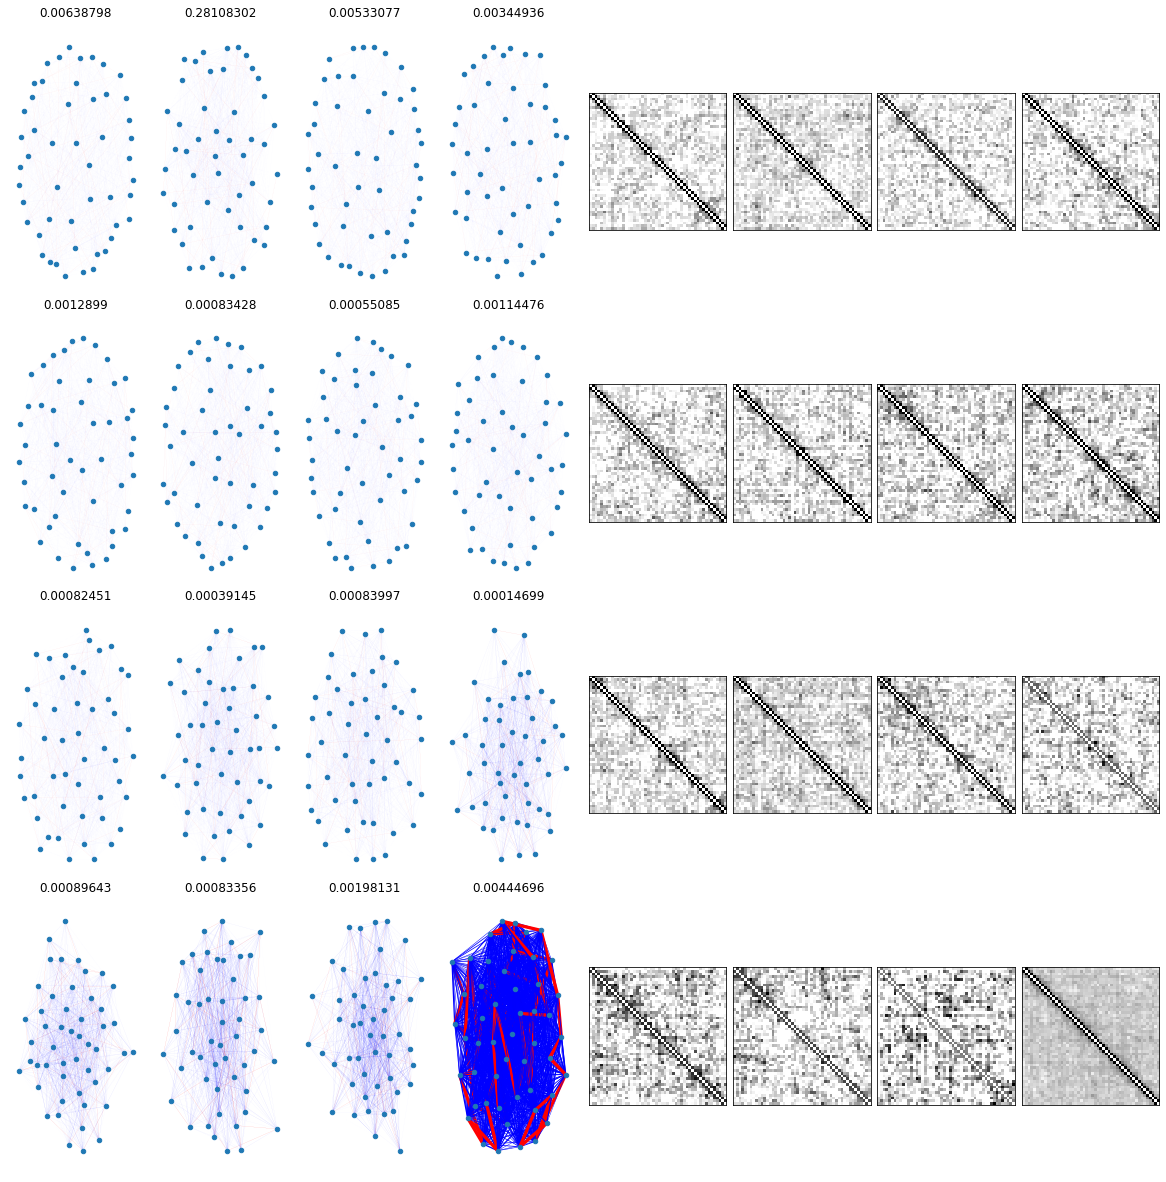

In [19]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 50, 
                       fig_size = [20,20], 
                       show_importance = False)

In [20]:
# SDL_BCD_filter
data_scale=10
results_dict_list_filter = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class_filter = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                       X_test = [X_test.T/data_scale, Y_test.T],
                                       n_components = r,
                                       xi = xi,
                                       L1_reg = [0,0,0],
                                       L2_reg = [0,0,0],
                                       nonnegativity = [True,True,False],
                                       full_dim = False)

        results_dict_new_filter = SDL_BCD_class_filter.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.46941651 -0.81498336  0.78667431 -0.82865808 -0.14029272  0.89285656
   0.86825906 -0.4650761   0.04700248 -0.05055049  0.86526579  0.84911556
   0.24552261 -0.11970899  0.62082509  0.04568761  0.85194963]]


  1%|▍                                          | 2/200 [00:00<00:34,  5.66it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [585.907309.3, 1249.085229.3, 1249.085229.3]


  6%|██▌                                       | 12/200 [00:02<00:34,  5.47it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.604]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.554687.3, 1249.057125.3, 1249.057125.3]


 11%|████▌                                     | 22/200 [00:03<00:31,  5.61it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.659]
--- Iteration 20: Training loss --- [Data, Label, Total] = [3.108491.3, 1248.858823.3, 1248.858823.3]


 16%|██████▋                                   | 32/200 [00:05<00:31,  5.33it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.713]
--- Iteration 30: Training loss --- [Data, Label, Total] = [3.261370.3, 1248.628790.3, 1248.628790.3]


 21%|████████▊                                 | 42/200 [00:07<00:29,  5.34it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.728]
--- Iteration 40: Training loss --- [Data, Label, Total] = [3.336487.3, 1248.595284.3, 1248.595284.3]


 26%|██████████▉                               | 52/200 [00:09<00:30,  4.92it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 50: Training loss --- [Data, Label, Total] = [3.350064.3, 1248.593836.3, 1248.593836.3]


 31%|█████████████                             | 62/200 [00:11<00:28,  4.86it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.351126.3, 1248.593813.3, 1248.593813.3]


 36%|███████████████                           | 72/200 [00:13<00:27,  4.63it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 70: Training loss --- [Data, Label, Total] = [3.351311.3, 1248.593815.3, 1248.593815.3]


 41%|█████████████████▏                        | 82/200 [00:15<00:23,  5.10it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 80: Training loss --- [Data, Label, Total] = [3.351344.3, 1248.593815.3, 1248.593815.3]


 46%|███████████████████▎                      | 92/200 [00:17<00:20,  5.31it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 90: Training loss --- [Data, Label, Total] = [3.351351.3, 1248.593815.3, 1248.593815.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:17,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3.351352.3, 1248.593815.3, 1248.593815.3]


 56%|██████████████████████▉                  | 112/200 [00:20<00:17,  4.90it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 110: Training loss --- [Data, Label, Total] = [3.351352.3, 1248.593815.3, 1248.593815.3]


 61%|█████████████████████████                | 122/200 [00:22<00:13,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 120: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 66%|██████████████████████████▊              | 131/200 [00:24<00:13,  5.02it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 130: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 71%|█████████████████████████████            | 142/200 [00:26<00:12,  4.67it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 140: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 76%|███████████████████████████████▏         | 152/200 [00:28<00:09,  4.89it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 150: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 81%|█████████████████████████████████▏       | 162/200 [00:30<00:08,  4.69it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 160: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 86%|███████████████████████████████████▎     | 172/200 [00:32<00:05,  4.68it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 170: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:34<00:03,  4.80it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 180: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:36<00:01,  4.80it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 190: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


100%|█████████████████████████████████████████| 200/200 [00:38<00:00,  5.24it/s]


!!! pred_type filter
initial loading beta [[ 0.99839011 -0.80714419  0.81438244  0.81520408 -0.01812851 -0.85956847
   0.18443792 -0.52574555 -0.18693954  0.24680534 -0.69479739 -0.39129597
  -0.82482252 -0.04223372 -0.96567912  0.73557691 -0.09070308]]


  1%|▍                                          | 2/200 [00:00<00:43,  4.51it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [586.940634.3, 1249.086132.3, 1249.086132.3]


  6%|██▎                                       | 11/200 [00:02<00:42,  4.47it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.604]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.543721.3, 1249.057995.3, 1249.057995.3]


 10%|████▍                                     | 21/200 [00:04<00:37,  4.75it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.659]
--- Iteration 20: Training loss --- [Data, Label, Total] = [3.107294.3, 1248.860212.3, 1248.860212.3]


 16%|██████▋                                   | 32/200 [00:06<00:34,  4.88it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.713]
--- Iteration 30: Training loss --- [Data, Label, Total] = [3.261437.3, 1248.629336.3, 1248.629336.3]


 21%|████████▊                                 | 42/200 [00:08<00:28,  5.53it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.728]
--- Iteration 40: Training loss --- [Data, Label, Total] = [3.336496.3, 1248.595299.3, 1248.595299.3]


 26%|██████████▋                               | 51/200 [00:10<00:30,  4.82it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 50: Training loss --- [Data, Label, Total] = [3.350063.3, 1248.593837.3, 1248.593837.3]


 31%|█████████████                             | 62/200 [00:12<00:27,  5.06it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.351126.3, 1248.593813.3, 1248.593813.3]


 36%|███████████████                           | 72/200 [00:14<00:23,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 70: Training loss --- [Data, Label, Total] = [3.351312.3, 1248.593815.3, 1248.593815.3]


 41%|█████████████████▏                        | 82/200 [00:15<00:20,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 80: Training loss --- [Data, Label, Total] = [3.351345.3, 1248.593815.3, 1248.593815.3]


 46%|███████████████████▎                      | 92/200 [00:17<00:18,  5.87it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 90: Training loss --- [Data, Label, Total] = [3.351351.3, 1248.593815.3, 1248.593815.3]


 51%|████████████████████▉                    | 102/200 [00:19<00:17,  5.52it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 56%|██████████████████████▉                  | 112/200 [00:20<00:15,  5.73it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 110: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 61%|█████████████████████████                | 122/200 [00:22<00:13,  5.93it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 120: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 66%|███████████████████████████              | 132/200 [00:24<00:11,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 130: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 71%|█████████████████████████████            | 142/200 [00:26<00:10,  5.51it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 140: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 76%|███████████████████████████████▏         | 152/200 [00:27<00:08,  5.89it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 150: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 81%|█████████████████████████████████▏       | 162/200 [00:29<00:06,  6.11it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 160: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 86%|███████████████████████████████████▎     | 172/200 [00:31<00:05,  5.30it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 170: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:32<00:03,  5.40it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 180: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:34<00:01,  5.43it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 190: Training loss --- [Data, Label, Total] = [3.351353.3, 1248.593815.3, 1248.593815.3]


100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.52it/s]


!!! pred_type filter
initial loading beta [[-0.74006446  0.26452949  0.32689804 -0.47030265  0.05830304  0.8492241
  -0.62445061 -0.33195604  0.24711274 -0.15597971  0.23359944 -0.75451564
   0.25145426 -0.56368183  0.07180602 -0.99676216  0.46158279]]


  1%|▍                                          | 2/200 [00:00<00:40,  4.92it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [608.328316.3, 1249.091722.3, 1309.924553.3]


  6%|██▌                                       | 12/200 [00:02<00:35,  5.27it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.6]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.651733.3, 1249.081876.3, 1249.447049.3]


 11%|████▌                                     | 22/200 [00:04<00:34,  5.22it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.633]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.825213.3, 1248.982651.3, 1249.265173.3]


 16%|██████▋                                   | 32/200 [00:05<00:30,  5.44it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.676]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.669058.3, 1248.810555.3, 1249.077460.3]


 21%|████████▊                                 | 42/200 [00:07<00:29,  5.27it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.704]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.570126.3, 1248.691640.3, 1248.948652.3]


 26%|██████████▉                               | 52/200 [00:09<00:28,  5.21it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.715]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.472498.3, 1248.646181.3, 1248.893430.3]


 30%|████████████▊                             | 61/200 [00:11<00:28,  4.86it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.721]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.409743.3, 1248.628283.3, 1248.869258.3]


 36%|███████████████                           | 72/200 [00:13<00:27,  4.64it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.724]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.380568.3, 1248.619275.3, 1248.857332.3]


 41%|█████████████████▏                        | 82/200 [00:15<00:25,  4.67it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.726]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.367342.3, 1248.614113.3, 1248.850847.3]


 46%|███████████████████▎                      | 92/200 [00:17<00:21,  5.05it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.727]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.360588.3, 1248.610855.3, 1248.846914.3]


 51%|████████████████████▉                    | 102/200 [00:19<00:17,  5.46it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.728]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.356783.3, 1248.608653.3, 1248.844331.3]


 56%|██████████████████████▉                  | 112/200 [00:21<00:15,  5.83it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.728]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.354306.3, 1248.607082.3, 1248.842513.3]


 61%|█████████████████████████                | 122/200 [00:22<00:14,  5.51it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.352502.3, 1248.605910.3, 1248.841160.3]


 66%|███████████████████████████              | 132/200 [00:24<00:12,  5.53it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.351079.3, 1248.605001.3, 1248.840109.3]


 70%|████████████████████████████▉            | 141/200 [00:26<00:11,  5.05it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.349911.3, 1248.604274.3, 1248.839265.3]


 76%|██████████████████████████████▉          | 151/200 [00:28<00:09,  4.95it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.348926.3, 1248.603676.3, 1248.838569.3]


 81%|█████████████████████████████████▏       | 162/200 [00:30<00:07,  5.15it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.348079.3, 1248.603174.3, 1248.837982.3]


 86%|███████████████████████████████████▎     | 172/200 [00:32<00:05,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.347342.3, 1248.602744.3, 1248.837478.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:33<00:03,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.346698.3, 1248.602370.3, 1248.837040.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:35<00:01,  4.51it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.346129.3, 1248.602042.3, 1248.836655.3]


100%|█████████████████████████████████████████| 200/200 [00:37<00:00,  5.33it/s]


!!! pred_type filter
initial loading beta [[-0.86063107  0.83582017 -0.06840631  0.9619828   0.37590335 -0.78685123
   0.44227419  0.23962477 -0.42337772 -0.47748097 -0.1542163   0.53869311
  -0.92050474  0.51206911 -0.27516629 -0.03211483 -0.0252589 ]]


  1%|▍                                          | 2/200 [00:00<00:45,  4.34it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.594]
--- Iteration 0: Training loss --- [Data, Label, Total] = [607.256766.3, 1249.090285.3, 1309.815961.3]


  6%|██▎                                       | 11/200 [00:02<00:36,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.601]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.622299.3, 1249.080768.3, 1249.442998.3]


 11%|████▌                                     | 22/200 [00:04<00:34,  5.09it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.634]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.823223.3, 1248.979569.3, 1249.261891.3]


 16%|██████▋                                   | 32/200 [00:05<00:29,  5.65it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.678]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.676659.3, 1248.804857.3, 1249.072523.3]


 21%|████████▊                                 | 42/200 [00:07<00:28,  5.54it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.704]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.578939.3, 1248.687743.3, 1248.945637.3]


 26%|██████████▉                               | 52/200 [00:09<00:26,  5.60it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.716]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.476725.3, 1248.644064.3, 1248.891736.3]


 31%|█████████████                             | 62/200 [00:11<00:26,  5.23it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.721]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.414755.3, 1248.627025.3, 1248.868501.3]


 36%|███████████████                           | 72/200 [00:13<00:24,  5.16it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.724]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.387871.3, 1248.618637.3, 1248.857424.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:22,  5.34it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.726]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.374166.3, 1248.613871.3, 1248.851287.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:21,  5.07it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.727]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.366005.3, 1248.610852.3, 1248.847452.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:20,  4.78it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.728]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.360667.3, 1248.608789.3, 1248.844855.3]


 56%|██████████████████████▊                  | 111/200 [00:20<00:19,  4.58it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.728]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.356961.3, 1248.607288.3, 1248.842984.3]


 60%|████████████████████████▊                | 121/200 [00:22<00:17,  4.48it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.354261.3, 1248.606146.3, 1248.841572.3]


 66%|██████████████████████████▊              | 131/200 [00:24<00:15,  4.54it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.352213.3, 1248.605244.3, 1248.840465.3]


 70%|████████████████████████████▉            | 141/200 [00:27<00:13,  4.43it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.350610.3, 1248.604511.3, 1248.839572.3]


 76%|███████████████████████████████▏         | 152/200 [00:29<00:10,  4.55it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.349320.3, 1248.603901.3, 1248.838833.3]


 81%|█████████████████████████████████▏       | 162/200 [00:31<00:08,  4.65it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.348258.3, 1248.603384.3, 1248.838210.3]


 86%|███████████████████████████████████▎     | 172/200 [00:33<00:05,  5.11it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.347368.3, 1248.602938.3, 1248.837675.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:35<00:03,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.346608.3, 1248.602550.3, 1248.837211.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:36<00:01,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.345952.3, 1248.602207.3, 1248.836802.3]


100%|█████████████████████████████████████████| 200/200 [00:38<00:00,  5.14it/s]


!!! pred_type filter
initial loading beta [[-0.19288235 -0.5762697  -0.24021574 -0.52855068  0.28985101 -0.46384823
  -0.45605879 -0.45502321  0.15905973  0.09642661  0.88927419  0.01384617
   0.65648708  0.01186897  0.20701409  0.26937879 -0.04867635]]


  0%|▏                                          | 1/200 [00:00<00:51,  3.90it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [763.918057.3, 1249.126826.3, 2013.044884.3]


  6%|██▌                                       | 12/200 [00:02<00:36,  5.14it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.595]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.769472.3, 1249.149685.3, 1252.919158.3]


 11%|████▌                                     | 22/200 [00:04<00:34,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.597]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.561952.3, 1249.145148.3, 1251.707100.3]


 16%|██████▋                                   | 32/200 [00:05<00:28,  5.86it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.6]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.419475.3, 1249.141107.3, 1251.560582.3]


 20%|████████▌                                 | 41/200 [00:07<00:29,  5.40it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.602]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.376797.3, 1249.137107.3, 1251.513904.3]


 26%|██████████▋                               | 51/200 [00:09<00:29,  5.07it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.605]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.357988.3, 1249.132954.3, 1251.490942.3]


 31%|█████████████                             | 62/200 [00:11<00:25,  5.40it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.607]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.347618.3, 1249.128583.3, 1251.476201.3]


 36%|███████████████                           | 72/200 [00:12<00:22,  5.75it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.61]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.341132.3, 1249.123968.3, 1251.465099.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:20,  5.63it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.612]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.336767.3, 1249.119095.3, 1251.455861.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:19,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.615]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.333682.3, 1249.113949.3, 1251.447631.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:16,  6.02it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.618]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.331428.3, 1249.108520.3, 1251.439948.3]


 56%|██████████████████████▊                  | 111/200 [00:19<00:15,  5.77it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.62]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.329734.3, 1249.102804.3, 1251.432538.3]


 61%|█████████████████████████                | 122/200 [00:21<00:13,  5.91it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.623]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.328430.3, 1249.096791.3, 1251.425221.3]


 66%|███████████████████████████              | 132/200 [00:22<00:11,  5.92it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.626]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.327402.3, 1249.090476.3, 1251.417878.3]


 71%|█████████████████████████████            | 142/200 [00:24<00:10,  5.75it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.628]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.326571.3, 1249.083863.3, 1251.410434.3]


 76%|███████████████████████████████▏         | 152/200 [00:26<00:08,  5.91it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.631]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.325884.3, 1249.076946.3, 1251.402830.3]


 81%|█████████████████████████████████▏       | 162/200 [00:27<00:06,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.633]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.325302.3, 1249.069720.3, 1251.395022.3]


 86%|███████████████████████████████████▎     | 172/200 [00:29<00:04,  5.90it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.636]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.324798.3, 1249.062185.3, 1251.386983.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:31<00:03,  5.84it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.639]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.324353.3, 1249.054330.3, 1251.378683.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:33<00:01,  4.54it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.642]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.323953.3, 1249.046181.3, 1251.370133.3]


100%|█████████████████████████████████████████| 200/200 [00:35<00:00,  5.69it/s]


!!! pred_type filter
initial loading beta [[ 0.47944372 -0.88542468 -0.55271655  0.36264627  0.323408    0.1322256
   0.7186229   0.67303996 -0.74354925  0.59063742  0.58724352 -0.39143418
  -0.73218179  0.74795617  0.90461457 -0.6085166  -0.45265599]]


  1%|▍                                          | 2/200 [00:00<00:34,  5.74it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [770.511692.3, 1249.127978.3, 2019.639671.3]


  6%|██▌                                       | 12/200 [00:02<00:32,  5.74it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.969241.3, 1249.154959.3, 1253.124200.3]


 11%|████▌                                     | 22/200 [00:03<00:30,  5.83it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.595]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.635139.3, 1249.150224.3, 1251.785363.3]


 16%|██████▋                                   | 32/200 [00:05<00:30,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.598]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.450657.3, 1249.145581.3, 1251.596238.3]


 21%|████████▊                                 | 42/200 [00:07<00:28,  5.50it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.601]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.391224.3, 1249.140989.3, 1251.532213.3]


 26%|██████████▉                               | 52/200 [00:09<00:26,  5.59it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.604]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.365489.3, 1249.136187.3, 1251.501676.3]


 31%|█████████████                             | 62/200 [00:10<00:23,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.607]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.352248.3, 1249.131062.3, 1251.483310.3]


 36%|███████████████                           | 72/200 [00:12<00:22,  5.76it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.61]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.344570.3, 1249.125552.3, 1251.470122.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:20,  5.65it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.613]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.339697.3, 1249.119623.3, 1251.459320.3]


 46%|███████████████████                       | 91/200 [00:15<00:25,  4.31it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.617]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.336376.3, 1249.113253.3, 1251.449629.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:18,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.62]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.333975.3, 1249.106421.3, 1251.440397.3]


 56%|██████████████████████▉                  | 112/200 [00:19<00:17,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.623]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.332156.3, 1249.099120.3, 1251.431276.3]


 61%|█████████████████████████                | 122/200 [00:21<00:15,  5.12it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.627]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.330720.3, 1249.091334.3, 1251.422055.3]


 66%|███████████████████████████              | 132/200 [00:23<00:12,  5.43it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.63]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.329548.3, 1249.083054.3, 1251.412603.3]


 71%|█████████████████████████████            | 142/200 [00:25<00:12,  4.72it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.633]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.328563.3, 1249.074277.3, 1251.402841.3]


 76%|██████████████████████████████▉          | 151/200 [00:28<00:15,  3.25it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.637]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.327716.3, 1249.065001.3, 1251.392717.3]


 81%|█████████████████████████████████▏       | 162/200 [00:30<00:07,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.64]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.326973.3, 1249.055222.3, 1251.382195.3]


 86%|███████████████████████████████████▎     | 172/200 [00:32<00:04,  5.74it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.644]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.326311.3, 1249.044958.3, 1251.371269.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:33<00:03,  5.86it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.647]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.325713.3, 1249.034210.3, 1251.359923.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:35<00:01,  5.11it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.65]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.325165.3, 1249.023001.3, 1251.348165.3]


100%|█████████████████████████████████████████| 200/200 [00:37<00:00,  5.35it/s]


!!! pred_type filter
initial loading beta [[-0.85401633 -0.69685906 -0.6605848   0.6979427   0.7914365   0.11579612
  -0.60465533  0.82077993 -0.52030127 -0.83869575  0.62207496  0.5256377
  -0.34997759 -0.08598694  0.9422488  -0.24234097  0.68785033]]


  1%|▍                                          | 2/200 [00:00<00:38,  5.11it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.596]
--- Iteration 0: Training loss --- [Data, Label, Total] = [705.492745.3, 1249.178452.3, 4776.642176.3]


  6%|██▌                                       | 12/200 [00:02<00:33,  5.55it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.591]
--- Iteration 10: Training loss --- [Data, Label, Total] = [5.601272.3, 1249.185765.3, 1277.192127.3]


 11%|████▌                                     | 22/200 [00:04<00:34,  5.09it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.591]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.588842.3, 1249.184922.3, 1262.129130.3]


 16%|██████▋                                   | 32/200 [00:05<00:32,  5.24it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.410346.3, 1249.184642.3, 1261.236371.3]


 21%|████████▊                                 | 42/200 [00:07<00:32,  4.90it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.375739.3, 1249.184423.3, 1261.063119.3]


 26%|██████████▉                               | 52/200 [00:09<00:29,  5.00it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.363856.3, 1249.184218.3, 1261.003497.3]


 30%|████████████▊                             | 61/200 [00:11<00:30,  4.54it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.357769.3, 1249.184018.3, 1260.972860.3]


 36%|███████████████                           | 72/200 [00:13<00:26,  4.89it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.353852.3, 1249.183821.3, 1260.953081.3]


 41%|█████████████████▏                        | 82/200 [00:16<00:24,  4.86it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.350969.3, 1249.183625.3, 1260.938469.3]


 46%|███████████████████▎                      | 92/200 [00:18<00:21,  5.12it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.594]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.348657.3, 1249.183431.3, 1260.926718.3]


 51%|████████████████████▉                    | 102/200 [00:20<00:24,  4.05it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.594]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.346710.3, 1249.183238.3, 1260.916786.3]


 56%|██████████████████████▉                  | 112/200 [00:22<00:17,  4.95it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.595]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.345008.3, 1249.183045.3, 1260.908085.3]


 61%|█████████████████████████                | 122/200 [00:24<00:14,  5.42it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.595]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.343489.3, 1249.182853.3, 1260.900299.3]


 66%|███████████████████████████              | 132/200 [00:25<00:12,  5.27it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.595]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.342115.3, 1249.182661.3, 1260.893236.3]


 71%|█████████████████████████████            | 142/200 [00:27<00:10,  5.40it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.596]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.340860.3, 1249.182469.3, 1260.886771.3]


 76%|███████████████████████████████▏         | 152/200 [00:29<00:09,  5.25it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.596]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.339709.3, 1249.182278.3, 1260.880822.3]


 81%|█████████████████████████████████▏       | 162/200 [00:31<00:07,  4.92it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.596]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.338651.3, 1249.182087.3, 1260.875344.3]


 86%|███████████████████████████████████▎     | 172/200 [00:33<00:05,  4.98it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.597]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.337678.3, 1249.181897.3, 1260.870286.3]


 90%|█████████████████████████████████████    | 181/200 [00:35<00:03,  5.73it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.597]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.336783.3, 1249.181707.3, 1260.865622.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:36<00:01,  5.96it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.597]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.335961.3, 1249.181517.3, 1260.861319.3]


100%|█████████████████████████████████████████| 200/200 [00:38<00:00,  5.22it/s]


!!! pred_type filter
initial loading beta [[-0.19917827 -0.97783623  0.67697575  0.13820499  0.73192069  0.32647633
   0.62828509  0.50683505  0.30274861  0.69616029 -0.52156299  0.38356338
   0.16898265  0.48072495 -0.49316906 -0.51536621 -0.40250765]]


  1%|▍                                          | 2/200 [00:00<00:34,  5.72it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [701.653774.3, 1249.179751.3, 4757.448622.3]


  6%|██▌                                       | 12/200 [00:02<00:35,  5.26it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.585]
--- Iteration 10: Training loss --- [Data, Label, Total] = [4.680338.3, 1249.190188.3, 1272.591876.3]


 11%|████▌                                     | 22/200 [00:03<00:31,  5.69it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.584]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.477192.3, 1249.189890.3, 1261.575849.3]


 16%|██████▋                                   | 32/200 [00:05<00:30,  5.59it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.585]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.386471.3, 1249.189709.3, 1261.122063.3]


 21%|████████▊                                 | 42/200 [00:07<00:30,  5.10it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.585]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.366259.3, 1249.189540.3, 1261.020835.3]


 26%|██████████▉                               | 52/200 [00:09<00:28,  5.12it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.586]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.358452.3, 1249.189373.3, 1260.981635.3]


 31%|█████████████                             | 62/200 [00:11<00:27,  4.98it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.586]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.354239.3, 1249.189205.3, 1260.960400.3]


 36%|███████████████                           | 72/200 [00:12<00:25,  5.02it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.586]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.351432.3, 1249.189035.3, 1260.946195.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:23,  5.08it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.587]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.349289.3, 1249.188865.3, 1260.935311.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:20,  5.34it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.587]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.347509.3, 1249.188693.3, 1260.926237.3]


 50%|████████████████████▋                    | 101/200 [00:18<00:19,  5.12it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.588]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.345950.3, 1249.188520.3, 1260.918267.3]


 56%|██████████████████████▊                  | 111/200 [00:20<00:16,  5.26it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.588]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.344540.3, 1249.188345.3, 1260.911042.3]


 61%|█████████████████████████                | 122/200 [00:22<00:17,  4.54it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.588]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.343240.3, 1249.188169.3, 1260.904369.3]


 66%|███████████████████████████              | 132/200 [00:24<00:13,  4.94it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.589]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.342030.3, 1249.187991.3, 1260.898139.3]


 71%|█████████████████████████████            | 142/200 [00:26<00:11,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.589]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.340896.3, 1249.187813.3, 1260.892295.3]


 76%|███████████████████████████████▏         | 152/200 [00:28<00:09,  5.29it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.59]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.339834.3, 1249.187633.3, 1260.886805.3]


 80%|█████████████████████████████████        | 161/200 [00:29<00:08,  4.58it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.59]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.338839.3, 1249.187454.3, 1260.881647.3]


 86%|███████████████████████████████████▎     | 172/200 [00:31<00:05,  5.48it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.591]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.337907.3, 1249.187273.3, 1260.876809.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:33<00:03,  5.64it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.591]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.337037.3, 1249.187093.3, 1260.872280.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:35<00:01,  5.58it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.591]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.336228.3, 1249.186912.3, 1260.868051.3]


100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.45it/s]


!!! pred_type filter
initial loading beta [[-0.20990953  0.05317196 -0.03263069  0.34739801 -0.41901028  0.96129752
  -0.29504138 -0.56030683  0.65759833  0.76410588 -0.20820344  0.70765195
  -0.97568866 -0.33882056 -0.22087165 -0.80266808 -0.83404464]]


  1%|▍                                          | 2/200 [00:00<00:38,  5.15it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.55]
--- Iteration 0: Training loss --- [Data, Label, Total] = [413.311036.3, 1249.199733.3, 5382.310091.3]


  6%|██▌                                       | 12/200 [00:02<00:34,  5.50it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.926891.3, 1249.199734.3, 1288.468645.3]


 11%|████▌                                     | 22/200 [00:03<00:29,  6.03it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 20: Training loss --- [Data, Label, Total] = [3.579057.3, 1249.199734.3, 1284.990301.3]


 16%|██████▋                                   | 32/200 [00:05<00:29,  5.77it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 30: Training loss --- [Data, Label, Total] = [3.560211.3, 1249.199734.3, 1284.801839.3]


 21%|████████▊                                 | 42/200 [00:07<00:29,  5.31it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 40: Training loss --- [Data, Label, Total] = [3.557876.3, 1249.199734.3, 1284.778491.3]


 26%|██████████▉                               | 52/200 [00:08<00:26,  5.55it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 50: Training loss --- [Data, Label, Total] = [3.556240.3, 1249.199734.3, 1284.762132.3]


 31%|█████████████                             | 62/200 [00:10<00:26,  5.16it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.554484.3, 1249.199734.3, 1284.744578.3]


 36%|███████████████                           | 72/200 [00:12<00:23,  5.36it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 70: Training loss --- [Data, Label, Total] = [3.552490.3, 1249.199734.3, 1284.724637.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:21,  5.36it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 80: Training loss --- [Data, Label, Total] = [3.550235.3, 1249.199734.3, 1284.702082.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:22,  4.75it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 90: Training loss --- [Data, Label, Total] = [3.547684.3, 1249.199734.3, 1284.676576.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:18,  5.33it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3.544796.3, 1249.199734.3, 1284.647698.3]


 56%|██████████████████████▉                  | 112/200 [00:20<00:17,  4.98it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 110: Training loss --- [Data, Label, Total] = [3.541536.3, 1249.199734.3, 1284.615098.3]


 61%|█████████████████████████                | 122/200 [00:22<00:15,  5.00it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 120: Training loss --- [Data, Label, Total] = [3.537836.3, 1249.199734.3, 1284.578098.3]


 66%|██████████████████████████▊              | 131/200 [00:23<00:14,  4.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 130: Training loss --- [Data, Label, Total] = [3.532688.3, 1249.199734.3, 1284.526614.3]


 71%|█████████████████████████████            | 142/200 [00:26<00:12,  4.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 140: Training loss --- [Data, Label, Total] = [3.526867.3, 1249.199734.3, 1284.468407.3]


 76%|██████████████████████████████▉          | 151/200 [00:28<00:11,  4.22it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 150: Training loss --- [Data, Label, Total] = [3.520524.3, 1249.199734.3, 1284.404972.3]


 81%|█████████████████████████████████▏       | 162/200 [00:30<00:08,  4.71it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 160: Training loss --- [Data, Label, Total] = [3.512605.3, 1249.199734.3, 1284.325789.3]


 86%|███████████████████████████████████▎     | 172/200 [00:32<00:05,  5.15it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 170: Training loss --- [Data, Label, Total] = [3.502464.3, 1249.199734.3, 1284.224374.3]


 90%|█████████████████████████████████████    | 181/200 [00:34<00:03,  4.92it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 180: Training loss --- [Data, Label, Total] = [3.489753.3, 1249.199734.3, 1284.097260.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:36<00:01,  5.27it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.534]
--- Iteration 190: Training loss --- [Data, Label, Total] = [3.473683.3, 1249.199734.3, 1283.936568.3]


100%|█████████████████████████████████████████| 200/200 [00:37<00:00,  5.31it/s]


!!! pred_type filter
initial loading beta [[ 0.33554587  0.62298141 -0.22486035 -0.00947763 -0.69410335 -0.72448924
   0.5077452  -0.96336582 -0.68858389 -0.37112045 -0.08184239  0.95027406
  -0.30638912 -0.3322098   0.91939782  0.92260923  0.18810428]]


  0%|▏                                          | 1/200 [00:00<01:00,  3.28it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.574]
--- Iteration 0: Training loss --- [Data, Label, Total] = [506.946251.3, 1249.199727.3, 6318.662238.3]


  6%|██▌                                       | 12/200 [00:02<00:31,  5.89it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.551]
--- Iteration 10: Training loss --- [Data, Label, Total] = [4.564770.3, 1249.198373.3, 1294.846070.3]


 10%|████▍                                     | 21/200 [00:04<00:35,  5.08it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.55]
--- Iteration 20: Training loss --- [Data, Label, Total] = [3.671812.3, 1249.198367.3, 1285.916488.3]


 16%|██████▋                                   | 32/200 [00:06<00:33,  4.97it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.55]
--- Iteration 30: Training loss --- [Data, Label, Total] = [3.587317.3, 1249.198362.3, 1285.071532.3]


 21%|████████▊                                 | 42/200 [00:08<00:31,  4.99it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.55]
--- Iteration 40: Training loss --- [Data, Label, Total] = [3.561875.3, 1249.198357.3, 1284.817110.3]


 26%|██████████▉                               | 52/200 [00:09<00:29,  5.05it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.55]
--- Iteration 50: Training loss --- [Data, Label, Total] = [3.549996.3, 1249.198352.3, 1284.698315.3]


 31%|█████████████                             | 62/200 [00:11<00:28,  4.78it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.55]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.542085.3, 1249.198346.3, 1284.619201.3]


 36%|███████████████                           | 72/200 [00:13<00:27,  4.71it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.55]
--- Iteration 70: Training loss --- [Data, Label, Total] = [3.535487.3, 1249.198340.3, 1284.553214.3]


 41%|█████████████████▏                        | 82/200 [00:15<00:24,  4.86it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.55]
--- Iteration 80: Training loss --- [Data, Label, Total] = [3.528532.3, 1249.198334.3, 1284.483651.3]


 46%|███████████████████▎                      | 92/200 [00:18<00:22,  4.87it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.551]
--- Iteration 90: Training loss --- [Data, Label, Total] = [3.521388.3, 1249.198328.3, 1284.412205.3]


 50%|████████████████████▋                    | 101/200 [00:19<00:20,  4.81it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.551]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3.511393.3, 1249.198322.3, 1284.312254.3]


 56%|██████████████████████▉                  | 112/200 [00:22<00:18,  4.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.551]
--- Iteration 110: Training loss --- [Data, Label, Total] = [3.499727.3, 1249.198315.3, 1284.195585.3]


 60%|████████████████████████▊                | 121/200 [00:23<00:17,  4.65it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.551]
--- Iteration 120: Training loss --- [Data, Label, Total] = [3.485227.3, 1249.198308.3, 1284.050577.3]


 66%|███████████████████████████              | 132/200 [00:26<00:13,  5.02it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.551]
--- Iteration 130: Training loss --- [Data, Label, Total] = [3.469393.3, 1249.198301.3, 1283.892231.3]


 70%|████████████████████████████▉            | 141/200 [00:27<00:12,  4.55it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.551]
--- Iteration 140: Training loss --- [Data, Label, Total] = [3.452691.3, 1249.198294.3, 1283.725207.3]


 76%|███████████████████████████████▏         | 152/200 [00:30<00:10,  4.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.551]
--- Iteration 150: Training loss --- [Data, Label, Total] = [3.433964.3, 1249.198286.3, 1283.537927.3]


 81%|█████████████████████████████████▏       | 162/200 [00:32<00:08,  4.66it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.552]
--- Iteration 160: Training loss --- [Data, Label, Total] = [3.410395.3, 1249.198278.3, 1283.302224.3]


 86%|███████████████████████████████████▎     | 172/200 [00:34<00:06,  4.65it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.552]
--- Iteration 170: Training loss --- [Data, Label, Total] = [3.381554.3, 1249.198269.3, 1283.013806.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:36<00:03,  5.38it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.552]
--- Iteration 180: Training loss --- [Data, Label, Total] = [3.351690.3, 1249.198260.3, 1282.715157.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:38<00:01,  5.54it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.552]
--- Iteration 190: Training loss --- [Data, Label, Total] = [3.320924.3, 1249.198251.3, 1282.407492.3]


100%|█████████████████████████████████████████| 200/200 [00:39<00:00,  5.08it/s]


!!! pred_type filter


In [21]:
W = results_dict_new_filter['loading'][0]
coeff = results_dict_new_filter['loading'][1][0]
H = results_dict_new_filter['code']

In [22]:
coeff

array([0.47030472, 0.00224731, 0.0025001 , 0.00214712, 0.00274691,
       0.01031375, 0.03505458, 0.00231177, 0.00257647, 0.0022045 ,
       0.00260863, 0.01154143, 0.00572678, 0.00195122, 0.00217584,
       0.0026059 , 0.00182265])

In [23]:
print('Accuracy: {}'.format(results_dict_new_filter['Accuracy']))
print('Training RRE: {}'.format(results_dict_new_filter['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new_filter['Relative_reconstruction_loss (test)']))

Accuracy: 0.5424
Training RRE: 0.9288341907957414
Testing RRE: 0.861625279183518


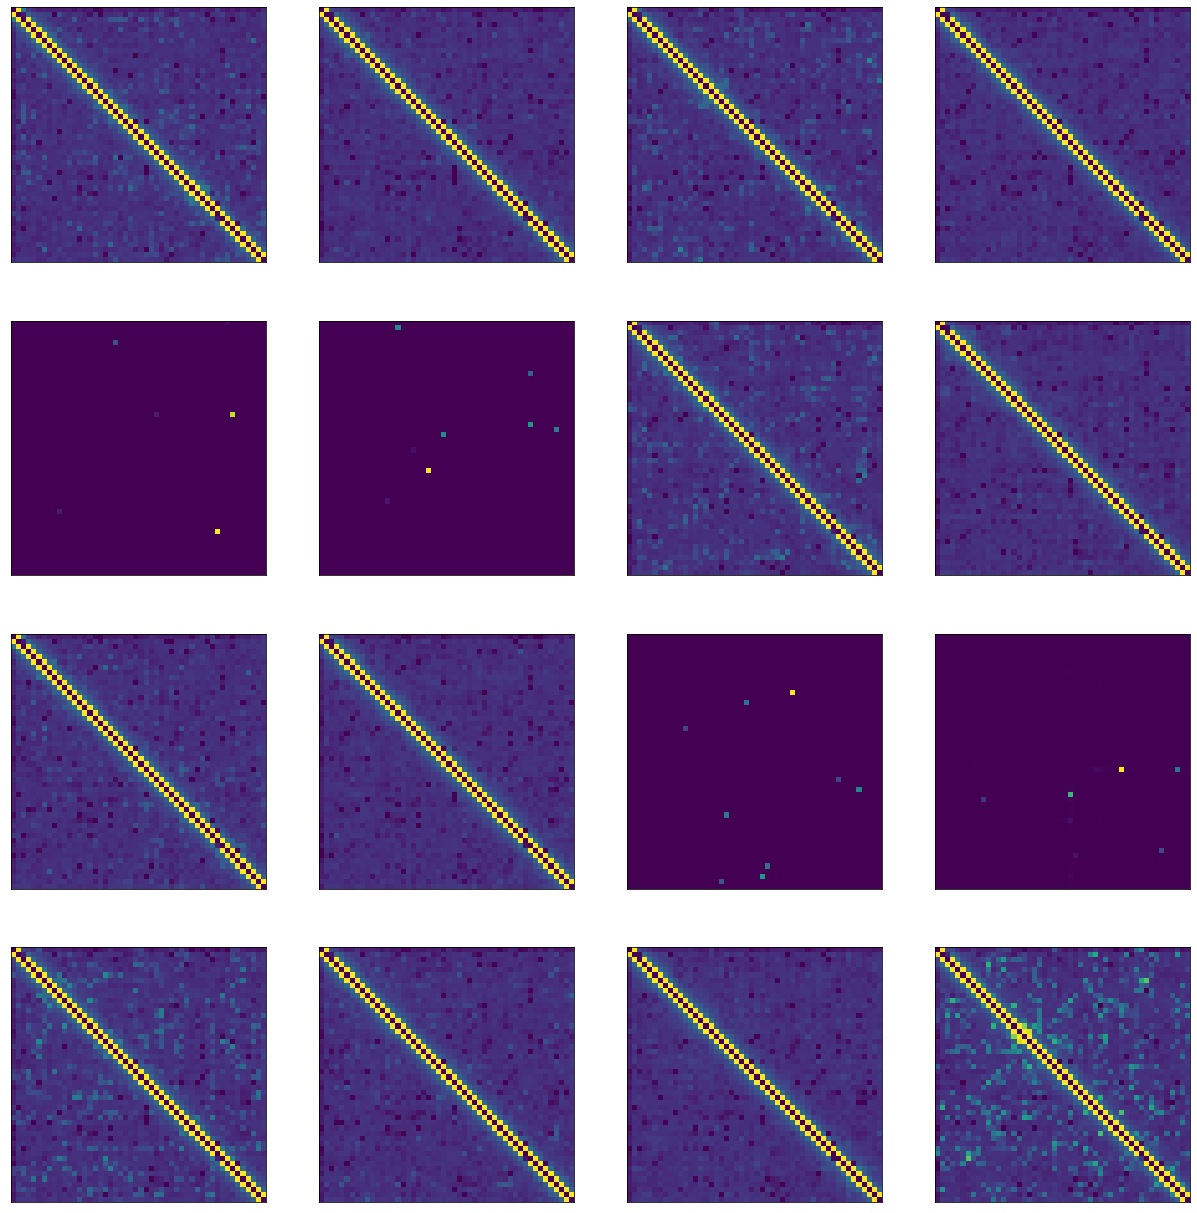

In [24]:
display_dictionary(W = W, figsize=[20,20])

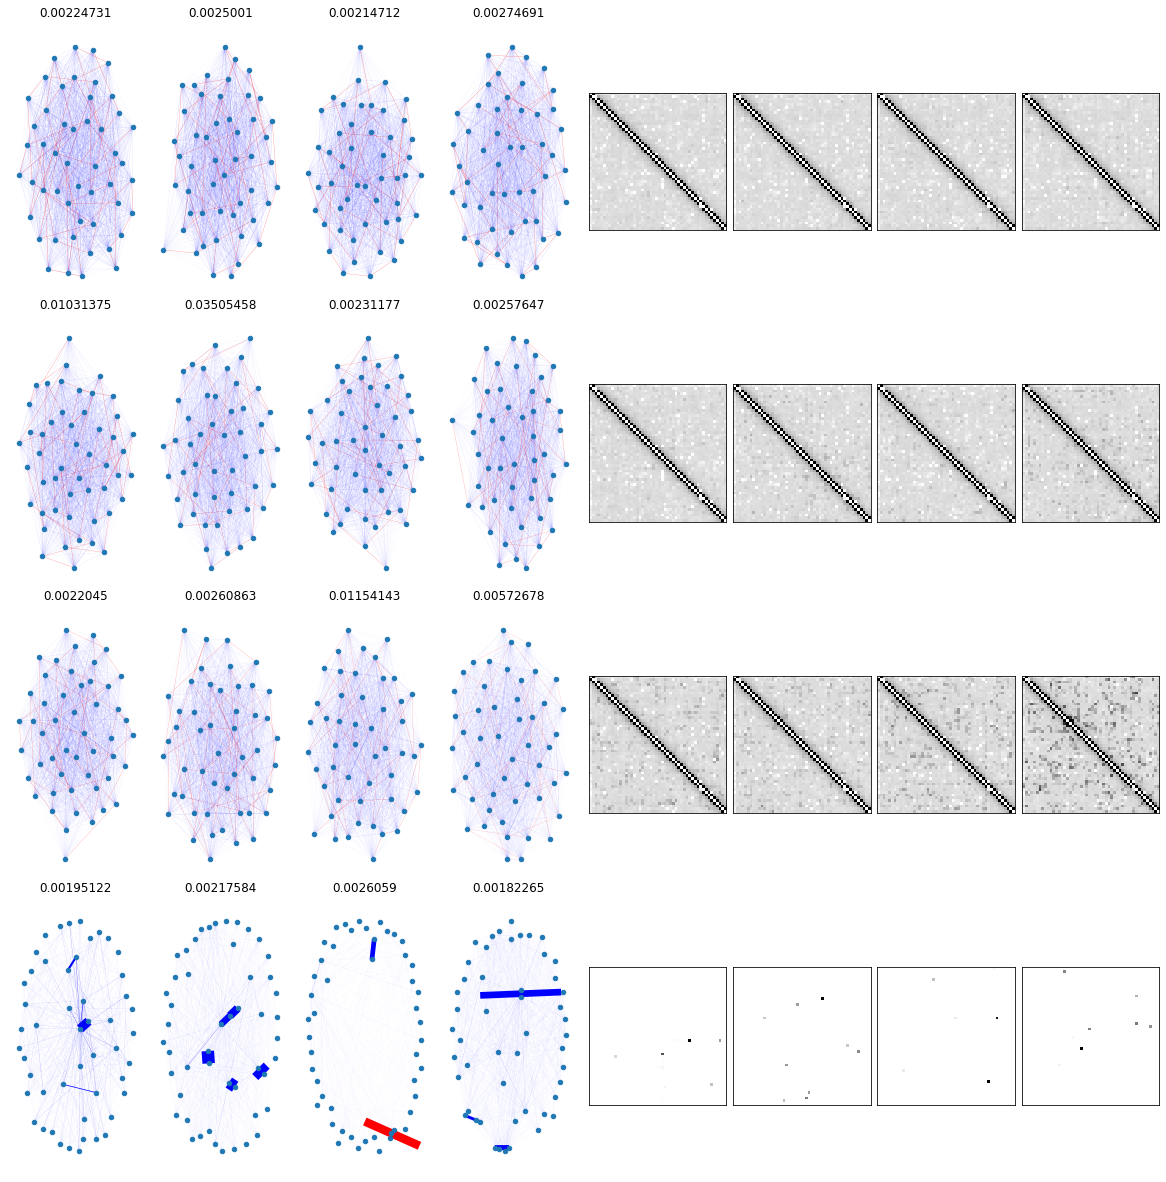

In [25]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 150, 
                       fig_size = [20,20], 
                       show_importance = True)

## 9 Dictionaries:


In [26]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  1%|▎                                         | 7/1000 [00:00<00:29, 34.15it/s]

iteration 0, reconstruction error 744027.756780


  2%|▌                                        | 15/1000 [00:00<00:30, 32.83it/s]

iteration 10, reconstruction error 515842.351791


  3%|█                                        | 27/1000 [00:00<00:28, 33.97it/s]

iteration 20, reconstruction error 513253.201432


  4%|█▍                                       | 35/1000 [00:01<00:28, 34.17it/s]

iteration 30, reconstruction error 504331.209653


  5%|█▉                                       | 47/1000 [00:01<00:27, 35.17it/s]

iteration 40, reconstruction error 487397.433656


  6%|██▎                                      | 55/1000 [00:01<00:27, 34.13it/s]

iteration 50, reconstruction error 477948.367919


  7%|██▋                                      | 67/1000 [00:01<00:28, 33.28it/s]

iteration 60, reconstruction error 475525.836723


  8%|███                                      | 75/1000 [00:02<00:30, 30.50it/s]

iteration 70, reconstruction error 474576.549091


  9%|███▌                                     | 87/1000 [00:02<00:29, 31.04it/s]

iteration 80, reconstruction error 474107.187588


 10%|███▉                                     | 95/1000 [00:02<00:27, 32.92it/s]

iteration 90, reconstruction error 473815.276568


 10%|████                                    | 103/1000 [00:03<00:29, 30.34it/s]

iteration 100, reconstruction error 473606.215315


 12%|████▌                                   | 115/1000 [00:03<00:29, 30.25it/s]

iteration 110, reconstruction error 473445.334733


 12%|█████                                   | 125/1000 [00:03<00:29, 29.23it/s]

iteration 120, reconstruction error 473315.353526


 14%|█████▍                                  | 137/1000 [00:04<00:27, 31.15it/s]

iteration 130, reconstruction error 473207.362934


 14%|█████▊                                  | 145/1000 [00:04<00:27, 30.74it/s]

iteration 140, reconstruction error 473115.767623


 16%|██████▎                                 | 157/1000 [00:04<00:26, 32.32it/s]

iteration 150, reconstruction error 473036.857232


 16%|██████▌                                 | 165/1000 [00:05<00:27, 30.77it/s]

iteration 160, reconstruction error 472968.288175


 18%|███████                                 | 177/1000 [00:05<00:25, 32.00it/s]

iteration 170, reconstruction error 472908.232947


 18%|███████▍                                | 185/1000 [00:05<00:25, 32.04it/s]

iteration 180, reconstruction error 472854.976664


 20%|███████▊                                | 196/1000 [00:06<00:29, 27.11it/s]

iteration 190, reconstruction error 472807.439580


 20%|████████▏                               | 204/1000 [00:06<00:27, 28.79it/s]

iteration 200, reconstruction error 472764.796259


 21%|████████▌                               | 214/1000 [00:06<00:29, 26.78it/s]

iteration 210, reconstruction error 472726.443381


 22%|█████████                               | 225/1000 [00:07<00:28, 27.64it/s]

iteration 220, reconstruction error 472691.668660


 23%|█████████▎                              | 234/1000 [00:07<00:40, 19.00it/s]

iteration 230, reconstruction error 472659.997192


 25%|█████████▊                              | 246/1000 [00:08<00:31, 23.85it/s]

iteration 240, reconstruction error 472631.021282


 26%|██████████▏                             | 256/1000 [00:08<00:27, 27.03it/s]

iteration 250, reconstruction error 472604.449157


 27%|██████████▋                             | 266/1000 [00:09<00:28, 25.46it/s]

iteration 260, reconstruction error 472579.927487


 28%|███████████                             | 276/1000 [00:09<00:27, 26.43it/s]

iteration 270, reconstruction error 472557.170333


 29%|███████████▌                            | 288/1000 [00:09<00:22, 31.59it/s]

iteration 280, reconstruction error 472535.943004


 30%|███████████▊                            | 296/1000 [00:10<00:21, 33.21it/s]

iteration 290, reconstruction error 472516.087303


 31%|████████████▎                           | 308/1000 [00:10<00:20, 34.16it/s]

iteration 300, reconstruction error 472497.483616


 32%|████████████▋                           | 316/1000 [00:10<00:19, 35.03it/s]

iteration 310, reconstruction error 472480.009905


 32%|████████████▉                           | 324/1000 [00:10<00:20, 32.89it/s]

iteration 320, reconstruction error 472463.542747


 34%|█████████████▍                          | 336/1000 [00:11<00:23, 28.67it/s]

iteration 330, reconstruction error 472447.971475


 34%|█████████████▊                          | 344/1000 [00:11<00:21, 30.69it/s]

iteration 340, reconstruction error 472433.242459


 36%|██████████████▏                         | 356/1000 [00:11<00:19, 33.21it/s]

iteration 350, reconstruction error 472419.273650


 36%|██████████████▌                         | 364/1000 [00:12<00:18, 33.69it/s]

iteration 360, reconstruction error 472405.986611


 38%|███████████████                         | 376/1000 [00:12<00:18, 33.48it/s]

iteration 370, reconstruction error 472393.342640


 39%|███████████████▌                        | 388/1000 [00:12<00:17, 34.53it/s]

iteration 380, reconstruction error 472381.281008


 40%|███████████████▊                        | 396/1000 [00:13<00:17, 33.77it/s]

iteration 390, reconstruction error 472369.759675


 41%|████████████████▎                       | 408/1000 [00:13<00:17, 34.15it/s]

iteration 400, reconstruction error 472358.748278


 42%|████████████████▋                       | 416/1000 [00:13<00:17, 34.08it/s]

iteration 410, reconstruction error 472348.225170


 42%|████████████████▉                       | 424/1000 [00:13<00:17, 33.51it/s]

iteration 420, reconstruction error 472338.188001


 44%|█████████████████▍                      | 436/1000 [00:14<00:16, 35.16it/s]

iteration 430, reconstruction error 472328.609786


 45%|█████████████████▉                      | 448/1000 [00:14<00:16, 33.10it/s]

iteration 440, reconstruction error 472319.460319


 46%|██████████████████▏                     | 456/1000 [00:14<00:16, 32.86it/s]

iteration 450, reconstruction error 472310.707852


 46%|██████████████████▌                     | 464/1000 [00:15<00:16, 32.63it/s]

iteration 460, reconstruction error 472302.329664


 48%|███████████████████                     | 476/1000 [00:15<00:16, 31.21it/s]

iteration 470, reconstruction error 472294.300083


 48%|███████████████████▎                    | 484/1000 [00:15<00:17, 30.09it/s]

iteration 480, reconstruction error 472286.594055


 50%|███████████████████▊                    | 495/1000 [00:16<00:17, 28.87it/s]

iteration 490, reconstruction error 472279.203264


 51%|████████████████████▎                   | 507/1000 [00:16<00:14, 33.25it/s]

iteration 500, reconstruction error 472272.098465


 52%|████████████████████▌                   | 515/1000 [00:16<00:14, 32.47it/s]

iteration 510, reconstruction error 472265.250642


 53%|█████████████████████                   | 527/1000 [00:17<00:15, 31.40it/s]

iteration 520, reconstruction error 472258.644093


 54%|█████████████████████▍                  | 535/1000 [00:17<00:14, 31.05it/s]

iteration 530, reconstruction error 472252.258955


 55%|█████████████████████▉                  | 547/1000 [00:17<00:14, 30.59it/s]

iteration 540, reconstruction error 472246.082874


 56%|██████████████████████▏                 | 555/1000 [00:18<00:14, 30.31it/s]

iteration 550, reconstruction error 472240.099850


 57%|██████████████████████▋                 | 567/1000 [00:18<00:12, 33.98it/s]

iteration 560, reconstruction error 472234.297865


 57%|███████████████████████                 | 575/1000 [00:18<00:12, 35.03it/s]

iteration 570, reconstruction error 472228.666417


 59%|███████████████████████▍                | 587/1000 [00:19<00:11, 35.58it/s]

iteration 580, reconstruction error 472223.190677


 60%|███████████████████████▊                | 595/1000 [00:19<00:11, 34.49it/s]

iteration 590, reconstruction error 472217.852664


 61%|████████████████████████▎               | 607/1000 [00:19<00:11, 35.52it/s]

iteration 600, reconstruction error 472212.629141


 62%|████████████████████████▌               | 615/1000 [00:19<00:11, 34.64it/s]

iteration 610, reconstruction error 472207.511718


 63%|█████████████████████████               | 627/1000 [00:20<00:11, 33.04it/s]

iteration 620, reconstruction error 472202.491570


 64%|█████████████████████████▍              | 635/1000 [00:20<00:11, 30.48it/s]

iteration 630, reconstruction error 472197.555011


 65%|█████████████████████████▉              | 647/1000 [00:20<00:11, 30.63it/s]

iteration 640, reconstruction error 472192.684197


 66%|██████████████████████████▏             | 655/1000 [00:21<00:10, 31.78it/s]

iteration 650, reconstruction error 472187.871778


 67%|██████████████████████████▋             | 667/1000 [00:21<00:09, 34.24it/s]

iteration 660, reconstruction error 472183.114903


 68%|███████████████████████████             | 675/1000 [00:21<00:09, 34.39it/s]

iteration 670, reconstruction error 472178.401467


 69%|███████████████████████████▍            | 687/1000 [00:22<00:09, 32.33it/s]

iteration 680, reconstruction error 472173.724872


 70%|███████████████████████████▊            | 695/1000 [00:22<00:09, 33.62it/s]

iteration 690, reconstruction error 472169.080808


 71%|████████████████████████████▎           | 707/1000 [00:22<00:08, 33.25it/s]

iteration 700, reconstruction error 472164.460615


 72%|████████████████████████████▌           | 715/1000 [00:22<00:08, 32.72it/s]

iteration 710, reconstruction error 472159.856612


 73%|█████████████████████████████           | 727/1000 [00:23<00:08, 31.60it/s]

iteration 720, reconstruction error 472155.266315


 74%|█████████████████████████████▍          | 735/1000 [00:23<00:08, 30.25it/s]

iteration 730, reconstruction error 472150.691914


 75%|█████████████████████████████▉          | 747/1000 [00:23<00:07, 32.44it/s]

iteration 740, reconstruction error 472146.140941


 76%|██████████████████████████████▏         | 755/1000 [00:24<00:07, 34.01it/s]

iteration 750, reconstruction error 472141.613432


 77%|██████████████████████████████▋         | 767/1000 [00:24<00:07, 31.51it/s]

iteration 760, reconstruction error 472137.115165


 78%|███████████████████████████████         | 775/1000 [00:24<00:07, 31.09it/s]

iteration 770, reconstruction error 472132.634734


 79%|███████████████████████████████▍        | 787/1000 [00:25<00:06, 32.46it/s]

iteration 780, reconstruction error 472128.170936


 80%|███████████████████████████████▊        | 795/1000 [00:25<00:06, 34.09it/s]

iteration 790, reconstruction error 472123.726090


 81%|████████████████████████████████▎       | 807/1000 [00:25<00:05, 32.45it/s]

iteration 800, reconstruction error 472119.292371


 82%|████████████████████████████████▌       | 815/1000 [00:26<00:05, 33.92it/s]

iteration 810, reconstruction error 472114.868205


 83%|█████████████████████████████████       | 827/1000 [00:26<00:05, 31.36it/s]

iteration 820, reconstruction error 472110.448081


 84%|█████████████████████████████████▍      | 835/1000 [00:26<00:05, 31.57it/s]

iteration 830, reconstruction error 472106.034333


 85%|█████████████████████████████████▉      | 848/1000 [00:27<00:04, 34.54it/s]

iteration 840, reconstruction error 472101.623019


 86%|██████████████████████████████████▏     | 856/1000 [00:27<00:04, 31.84it/s]

iteration 850, reconstruction error 472097.211850


 86%|██████████████████████████████████▌     | 864/1000 [00:27<00:04, 31.61it/s]

iteration 860, reconstruction error 472092.804499


 88%|███████████████████████████████████     | 876/1000 [00:27<00:03, 34.37it/s]

iteration 870, reconstruction error 472088.425049


 88%|███████████████████████████████████▎    | 884/1000 [00:28<00:03, 32.77it/s]

iteration 880, reconstruction error 472084.082362


 90%|███████████████████████████████████▊    | 896/1000 [00:28<00:03, 33.03it/s]

iteration 890, reconstruction error 472079.785177


 90%|████████████████████████████████████▏   | 904/1000 [00:28<00:03, 30.51it/s]

iteration 900, reconstruction error 472075.533737


 92%|████████████████████████████████████▌   | 915/1000 [00:29<00:02, 29.73it/s]

iteration 910, reconstruction error 472071.323617


 93%|█████████████████████████████████████   | 927/1000 [00:29<00:02, 31.93it/s]

iteration 920, reconstruction error 472067.154030


 94%|█████████████████████████████████████▍  | 935/1000 [00:29<00:01, 33.74it/s]

iteration 930, reconstruction error 472063.038099


 95%|█████████████████████████████████████▉  | 947/1000 [00:30<00:01, 34.90it/s]

iteration 940, reconstruction error 472058.993116


 96%|██████████████████████████████████████▏ | 955/1000 [00:30<00:01, 32.96it/s]

iteration 950, reconstruction error 472055.013286


 97%|██████████████████████████████████████▋ | 967/1000 [00:30<00:01, 32.79it/s]

iteration 960, reconstruction error 472051.094126


 98%|███████████████████████████████████████ | 975/1000 [00:30<00:00, 32.95it/s]

iteration 970, reconstruction error 472047.236475


 99%|███████████████████████████████████████▍| 987/1000 [00:31<00:00, 33.15it/s]

iteration 980, reconstruction error 472043.433261


100%|███████████████████████████████████████▊| 995/1000 [00:31<00:00, 31.31it/s]

iteration 990, reconstruction error 472039.683544


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.47it/s]




###########################
Shape of W_true: (2500, 9)
###########################




  0%|▏                                         | 5/1000 [00:00<00:22, 44.59it/s]

iteration 0, reconstruction error 444540.870948


  1%|▍                                        | 11/1000 [00:00<00:20, 47.56it/s]

iteration 10, reconstruction error 307376.556686


  3%|█                                        | 26/1000 [00:00<00:22, 42.56it/s]

iteration 20, reconstruction error 305097.378834


  4%|█▌                                       | 37/1000 [00:00<00:20, 46.43it/s]

iteration 30, reconstruction error 297287.310835


  5%|█▉                                       | 48/1000 [00:01<00:19, 49.85it/s]

iteration 40, reconstruction error 286421.904579
iteration 50, reconstruction error 283268.000461


  7%|██▋                                      | 66/1000 [00:01<00:19, 48.74it/s]

iteration 60, reconstruction error 282164.096517
iteration 70, reconstruction error 281677.903932


  9%|███▋                                     | 90/1000 [00:01<00:18, 48.66it/s]

iteration 80, reconstruction error 281407.392052


 10%|███▉                                     | 95/1000 [00:01<00:19, 46.62it/s]

iteration 90, reconstruction error 281229.604443


 11%|████▏                                   | 106/1000 [00:02<00:19, 46.72it/s]

iteration 100, reconstruction error 281100.118255


 12%|████▋                                   | 117/1000 [00:02<00:19, 46.44it/s]

iteration 110, reconstruction error 280999.188157
iteration 120, reconstruction error 280917.081092


 14%|█████▌                                  | 138/1000 [00:02<00:18, 47.10it/s]

iteration 130, reconstruction error 280847.943725


 15%|█████▉                                  | 148/1000 [00:03<00:18, 46.93it/s]

iteration 140, reconstruction error 280788.938334


 16%|██████▎                                 | 158/1000 [00:03<00:18, 46.13it/s]

iteration 150, reconstruction error 280737.608207


 17%|██████▊                                 | 169/1000 [00:03<00:17, 47.76it/s]

iteration 160, reconstruction error 280692.106020
iteration 170, reconstruction error 280651.297226


 19%|███████▍                                | 187/1000 [00:03<00:15, 52.37it/s]

iteration 180, reconstruction error 280614.510781
iteration 190, reconstruction error 280581.075700


 21%|████████▍                               | 211/1000 [00:04<00:15, 50.57it/s]

iteration 200, reconstruction error 280550.554207
iteration 210, reconstruction error 280522.391894


 23%|█████████▏                              | 229/1000 [00:04<00:15, 51.09it/s]

iteration 220, reconstruction error 280496.251261
iteration 230, reconstruction error 280471.955388


 25%|█████████▉                              | 247/1000 [00:05<00:14, 52.11it/s]

iteration 240, reconstruction error 280449.328708
iteration 250, reconstruction error 280428.135319


 27%|██████████▊                             | 271/1000 [00:05<00:14, 51.26it/s]

iteration 260, reconstruction error 280408.285478
iteration 270, reconstruction error 280389.795854


 29%|███████████▌                            | 289/1000 [00:05<00:13, 51.53it/s]

iteration 280, reconstruction error 280372.514036
iteration 290, reconstruction error 280356.341914


 31%|████████████▎                           | 307/1000 [00:06<00:12, 53.38it/s]

iteration 300, reconstruction error 280341.227861
iteration 310, reconstruction error 280327.048888


 33%|█████████████▏                          | 331/1000 [00:06<00:13, 51.32it/s]

iteration 320, reconstruction error 280313.691389
iteration 330, reconstruction error 280301.108977


 35%|█████████████▉                          | 349/1000 [00:07<00:12, 50.40it/s]

iteration 340, reconstruction error 280289.221168


 36%|██████████████▏                         | 355/1000 [00:07<00:13, 48.48it/s]

iteration 350, reconstruction error 280278.001476


 37%|██████████████▋                         | 367/1000 [00:07<00:12, 51.16it/s]

iteration 360, reconstruction error 280267.365289
iteration 370, reconstruction error 280257.237231


 39%|███████████████▌                        | 389/1000 [00:07<00:13, 44.96it/s]

iteration 380, reconstruction error 280247.568669


 40%|████████████████                        | 400/1000 [00:08<00:13, 44.23it/s]

iteration 390, reconstruction error 280238.328795


 40%|████████████████▏                       | 405/1000 [00:08<00:13, 43.88it/s]

iteration 400, reconstruction error 280229.497541


 42%|████████████████▋                       | 416/1000 [00:08<00:12, 47.12it/s]

iteration 410, reconstruction error 280221.041436


 43%|█████████████████                       | 426/1000 [00:08<00:12, 44.88it/s]

iteration 420, reconstruction error 280212.908334


 44%|█████████████████▌                      | 438/1000 [00:08<00:11, 49.88it/s]

iteration 430, reconstruction error 280205.067231
iteration 440, reconstruction error 280197.513736


 46%|██████████████████▏                     | 456/1000 [00:09<00:11, 47.86it/s]

iteration 450, reconstruction error 280190.224351


 47%|██████████████████▋                     | 466/1000 [00:09<00:11, 45.99it/s]

iteration 460, reconstruction error 280183.184164


 48%|███████████████████                     | 477/1000 [00:09<00:10, 48.22it/s]

iteration 470, reconstruction error 280176.374847


 49%|███████████████████▍                    | 487/1000 [00:10<00:11, 46.13it/s]

iteration 480, reconstruction error 280169.796122


 50%|███████████████████▉                    | 497/1000 [00:10<00:11, 43.63it/s]

iteration 490, reconstruction error 280163.440148


 51%|████████████████████▎                   | 508/1000 [00:10<00:10, 44.90it/s]

iteration 500, reconstruction error 280157.309880


 52%|████████████████████▊                   | 519/1000 [00:10<00:10, 47.46it/s]

iteration 510, reconstruction error 280151.387152
iteration 520, reconstruction error 280145.661253


 54%|█████████████████████▍                  | 537/1000 [00:11<00:09, 50.12it/s]

iteration 530, reconstruction error 280140.129143
iteration 540, reconstruction error 280134.787381


 56%|██████████████████████▍                 | 561/1000 [00:11<00:08, 51.97it/s]

iteration 550, reconstruction error 280129.631004
iteration 560, reconstruction error 280124.653354


 58%|███████████████████████▏                | 579/1000 [00:11<00:07, 54.27it/s]

iteration 570, reconstruction error 280119.844832
iteration 580, reconstruction error 280115.192742


 60%|███████████████████████▉                | 597/1000 [00:12<00:07, 50.61it/s]

iteration 590, reconstruction error 280110.685010
iteration 600, reconstruction error 280106.322910


 62%|████████████████████████▌               | 615/1000 [00:12<00:07, 49.88it/s]

iteration 610, reconstruction error 280102.108998


 63%|█████████████████████████               | 627/1000 [00:12<00:07, 50.49it/s]

iteration 620, reconstruction error 280098.028104
iteration 630, reconstruction error 280094.080659


 65%|█████████████████████████▉              | 649/1000 [00:13<00:07, 47.36it/s]

iteration 640, reconstruction error 280090.262100


 66%|██████████████████████████▏             | 655/1000 [00:13<00:07, 48.14it/s]

iteration 650, reconstruction error 280086.560521


 67%|██████████████████████████▋             | 666/1000 [00:13<00:07, 46.60it/s]

iteration 660, reconstruction error 280082.963543


 68%|███████████████████████████             | 676/1000 [00:13<00:06, 47.27it/s]

iteration 670, reconstruction error 280079.459482


 69%|███████████████████████████▍            | 687/1000 [00:14<00:06, 49.07it/s]

iteration 680, reconstruction error 280076.037302
iteration 690, reconstruction error 280072.689471


 71%|████████████████████████████▍           | 710/1000 [00:14<00:05, 50.88it/s]

iteration 700, reconstruction error 280069.409595
iteration 710, reconstruction error 280066.187908


 73%|█████████████████████████████           | 728/1000 [00:14<00:05, 49.39it/s]

iteration 720, reconstruction error 280063.020633


 74%|█████████████████████████████▌          | 739/1000 [00:15<00:05, 49.15it/s]

iteration 730, reconstruction error 280059.899831
iteration 740, reconstruction error 280056.819156


 76%|██████████████████████████████▏         | 756/1000 [00:15<00:04, 49.90it/s]

iteration 750, reconstruction error 280053.771115


 77%|██████████████████████████████▋         | 767/1000 [00:15<00:04, 47.97it/s]

iteration 760, reconstruction error 280050.753163


 78%|███████████████████████████████         | 778/1000 [00:15<00:04, 49.22it/s]

iteration 770, reconstruction error 280047.765766
iteration 780, reconstruction error 280044.810721


 80%|███████████████████████████████▊        | 795/1000 [00:16<00:03, 51.25it/s]

iteration 790, reconstruction error 280041.891997


 81%|████████████████████████████████▎       | 807/1000 [00:16<00:03, 49.68it/s]

iteration 800, reconstruction error 280039.022353
iteration 810, reconstruction error 280036.190633


 83%|█████████████████████████████████▏      | 831/1000 [00:16<00:03, 51.12it/s]

iteration 820, reconstruction error 280033.396887
iteration 830, reconstruction error 280030.639867


 85%|█████████████████████████████████▉      | 849/1000 [00:17<00:02, 50.75it/s]

iteration 840, reconstruction error 280027.913546


 86%|██████████████████████████████████▍     | 861/1000 [00:17<00:02, 50.28it/s]

iteration 850, reconstruction error 280025.222623
iteration 860, reconstruction error 280022.559084


 88%|███████████████████████████████████▏    | 879/1000 [00:17<00:02, 51.55it/s]

iteration 870, reconstruction error 280019.922209
iteration 880, reconstruction error 280017.316996


 90%|███████████████████████████████████▉    | 897/1000 [00:18<00:02, 51.38it/s]

iteration 890, reconstruction error 280014.740110
iteration 900, reconstruction error 280012.187436


 92%|████████████████████████████████████▊   | 921/1000 [00:18<00:01, 50.08it/s]

iteration 910, reconstruction error 280009.657579
iteration 920, reconstruction error 280007.151394


 94%|█████████████████████████████████████▌  | 939/1000 [00:19<00:01, 51.64it/s]

iteration 930, reconstruction error 280004.666947
iteration 940, reconstruction error 280002.203776


 96%|██████████████████████████████████████▏ | 956/1000 [00:19<00:00, 49.11it/s]

iteration 950, reconstruction error 279999.762444
iteration 960, reconstruction error 279997.343757


 98%|███████████████████████████████████████▏| 979/1000 [00:19<00:00, 47.98it/s]

iteration 970, reconstruction error 279994.956806


 99%|███████████████████████████████████████▌| 989/1000 [00:20<00:00, 46.62it/s]

iteration 980, reconstruction error 279992.593671


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.98it/s]

iteration 990, reconstruction error 279990.249236


###########################
Shape of W_false: (2500, 9)
###########################




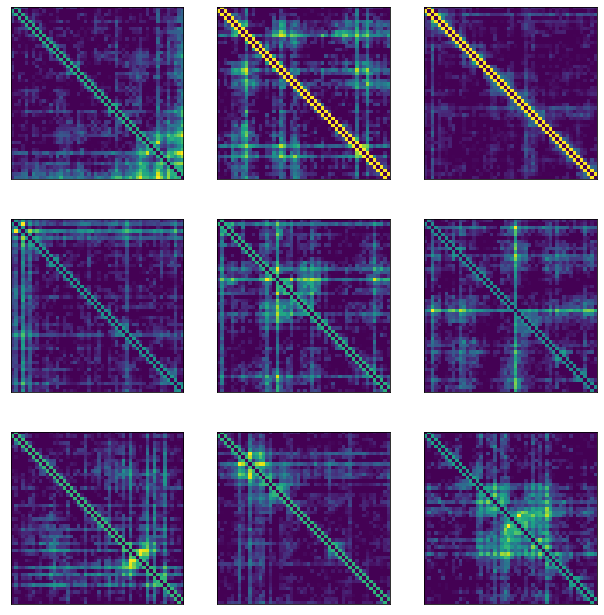

In [27]:
display_dictionary(W = W_true,
                   figsize = [10,10])

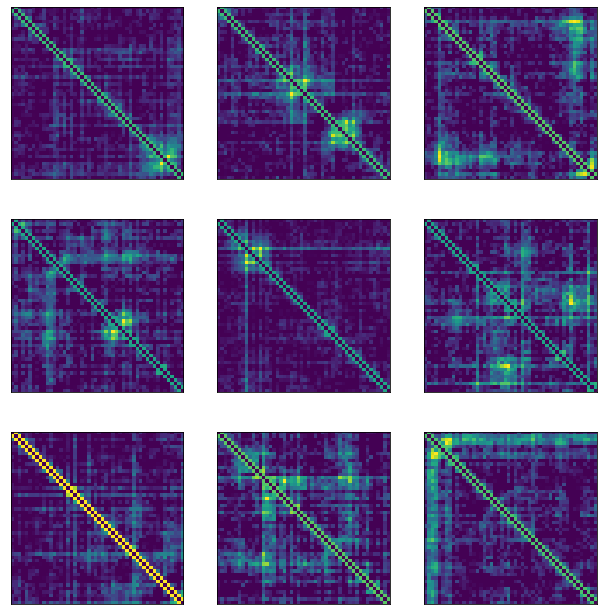

In [28]:
display_dictionary(W = W_false,
                   figsize = [10,10])

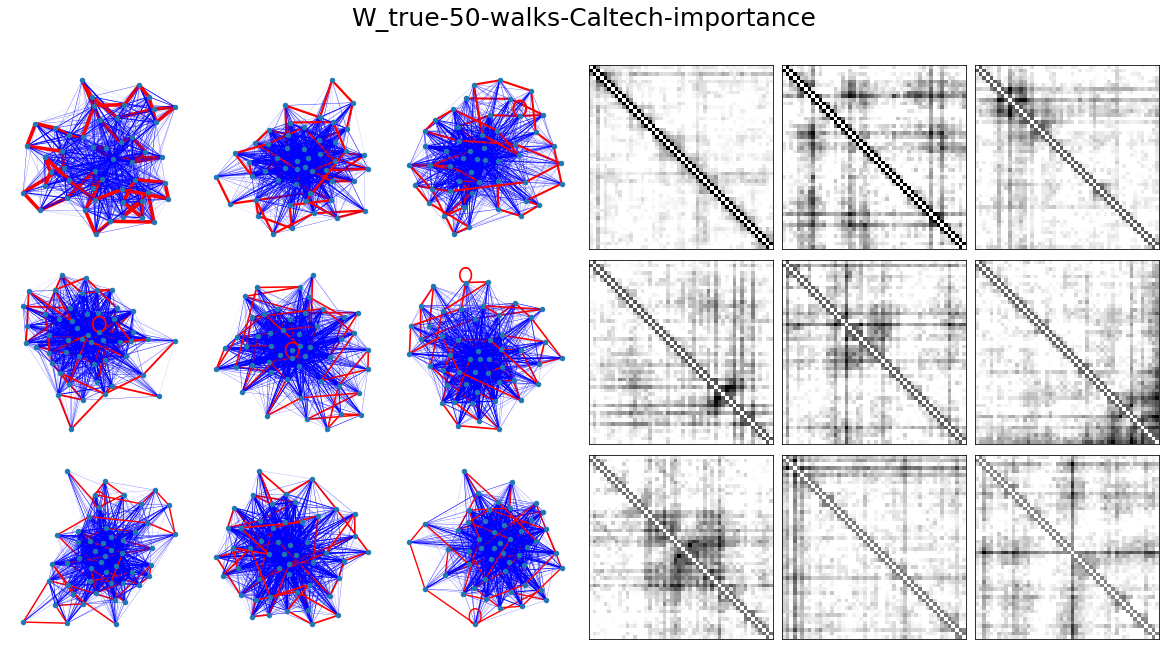

In [29]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_9Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

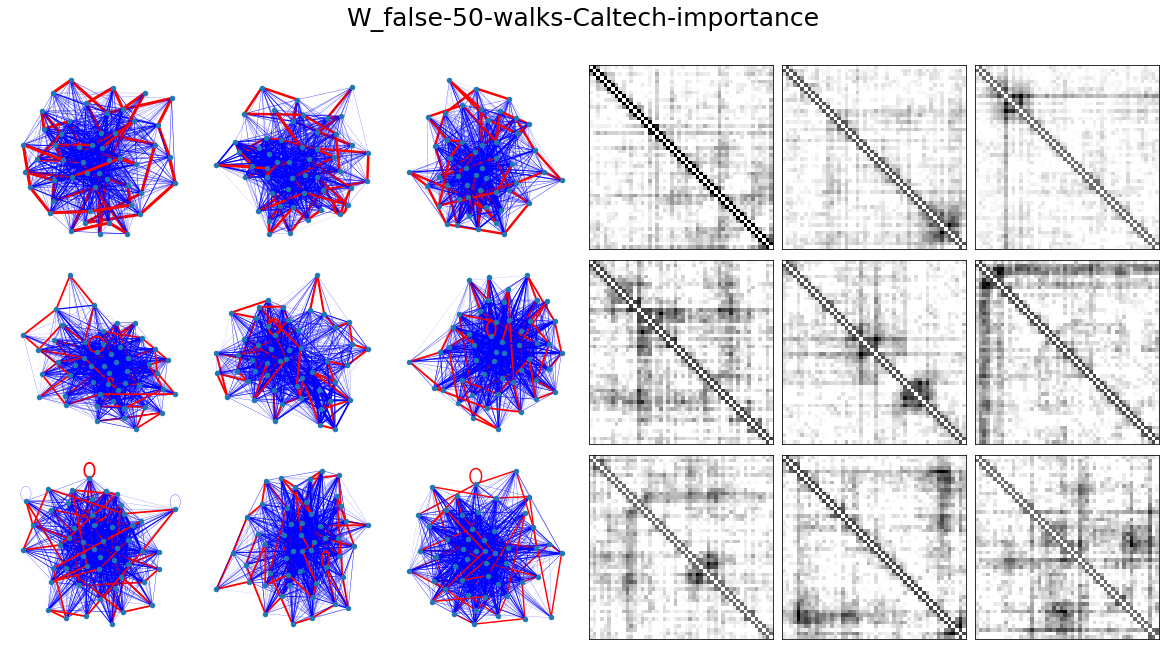

In [30]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_9Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

In [31]:
# SDL_BCD_feature
data_scale=10
results_dict_list9 = []
iteration1 = 200
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class9 = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                X_test = [X_test.T/data_scale, Y_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new9 = SDL_BCD_class9.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.69309378  0.89487147 -0.29365657  0.07221223 -0.44256598 -0.63478201
   0.64850943  0.55183582 -0.50508013  0.39153809]]


  0%|▏                                          | 1/200 [00:00<00:19,  9.97it/s]

--- Training --- [threshold, AUC] =  [0.611, 0.414]
--- Iteration 0: Training loss --- [Data, Label, Total] = [666.772234.3, 1249.323160.3, 1249.323160.3]


  5%|██                                        | 10/200 [00:00<00:07, 25.99it/s]


--- Training --- [threshold, AUC] =  [0.308, 0.719]
--- Iteration 10: Training loss --- [Data, Label, Total] = [977.491024.3, 1625.092873.3, 1625.092873.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.52381232  0.06050368 -0.88618907 -0.05769622 -0.14193342 -0.73463486
   0.48792037 -0.02566062  0.35180886  0.57535824]]


  4%|█▌                                         | 7/200 [00:00<00:06, 31.92it/s]

--- Training --- [threshold, AUC] =  [0.6, 0.414]
--- Iteration 0: Training loss --- [Data, Label, Total] = [650.503266.3, 1250.201862.3, 1250.201862.3]


  5%|██                                        | 10/200 [00:00<00:07, 25.27it/s]


--- Training --- [threshold, AUC] =  [0.046, 0.431]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1015.332399.3, 3608.481892.3, 3608.481892.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.53297354 -0.22741483  0.48495879  0.96730467  0.31386189  0.67009051
  -0.44677384 -0.83959125  0.23956869 -0.15343964]]


  3%|█▎                                         | 6/200 [00:00<00:07, 26.99it/s]

--- Training --- [threshold, AUC] =  [0.651, 0.414]
--- Iteration 0: Training loss --- [Data, Label, Total] = [644.090961.3, 1254.255233.3, 1318.664330.3]


  5%|██                                        | 10/200 [00:00<00:08, 21.69it/s]


--- Training --- [threshold, AUC] =  [0.981, 0.633]
--- Iteration 10: Training loss --- [Data, Label, Total] = [905.794853.3, 2895.729161.3, 2986.308646.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.63823539 -0.69472043 -0.57877329  0.34443852  0.00559372  0.31761933
   0.26324033 -0.22577744 -0.11556696  0.52519309]]


  3%|█▎                                         | 6/200 [00:00<00:06, 28.92it/s]

--- Training --- [threshold, AUC] =  [1.63, 0.425]
--- Iteration 0: Training loss --- [Data, Label, Total] = [630.043217.3, 1250.043504.3, 1313.047826.3]


  5%|██                                        | 10/200 [00:00<00:08, 22.90it/s]


--- Training --- [threshold, AUC] =  [0.948, 0.732]
--- Iteration 10: Training loss --- [Data, Label, Total] = [898.066392.3, 2198.260332.3, 2288.066971.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.02304724  0.56611658 -0.61667529 -0.09887937 -0.36970107 -0.4671421
   0.2016044   0.69468875  0.51864002  0.77705499]]


  2%|▋                                          | 3/200 [00:00<00:07, 25.86it/s]

--- Training --- [threshold, AUC] =  [0.528, 0.415]
--- Iteration 0: Training loss --- [Data, Label, Total] = [635.659579.3, 1278.636823.3, 1914.296402.3]


  5%|██                                        | 10/200 [00:00<00:07, 26.53it/s]


--- Training --- [threshold, AUC] =  [0.004, 0.601]
--- Iteration 10: Training loss --- [Data, Label, Total] = [552.948229.3, 6381.546083.3, 6934.494312.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.75645829 -0.84377996 -0.16169241 -0.53812227 -0.70626527  0.60480922
  -0.46580202 -0.19087119  0.85916913  0.70216614]]


  3%|█▎                                         | 6/200 [00:00<00:07, 27.58it/s]

--- Training --- [threshold, AUC] =  [0.648, 0.586]
--- Iteration 0: Training loss --- [Data, Label, Total] = [605.482203.3, 1253.429109.3, 1858.911311.3]


  5%|██                                        | 10/200 [00:00<00:07, 24.20it/s]


--- Training --- [threshold, AUC] =  [0.954, 0.596]
--- Iteration 10: Training loss --- [Data, Label, Total] = [536.039490.3, 2266.083342.3, 2802.122832.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.17000523  0.76749923  0.78521189  0.86518154  0.73547913  0.33320975
  -0.70648856  0.77477697  0.4946616  -0.05315765]]


  3%|█▎                                         | 6/200 [00:00<00:07, 25.92it/s]

--- Training --- [threshold, AUC] =  [0.639, 0.414]
--- Iteration 0: Training loss --- [Data, Label, Total] = [534.855069.3, 1251.341973.3, 3925.617318.3]


  7%|██▉                                       | 14/200 [00:00<00:06, 28.11it/s]

--- Training --- [threshold, AUC] =  [0.392, 0.427]
--- Iteration 10: Training loss --- [Data, Label, Total] = [271.029238.3, 1445.815334.3, 2800.961526.3]


 10%|████▏                                     | 20/200 [00:00<00:07, 23.88it/s]


--- Training --- [threshold, AUC] =  [0.111, 0.447]
--- Iteration 20: Training loss --- [Data, Label, Total] = [162.234071.3, 2631.898868.3, 3443.069224.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.08112954 -0.16937303 -0.64536649  0.68658973  0.71681443 -0.36452874
   0.46156375 -0.43440753 -0.33321991 -0.46835585]]


  0%|▏                                          | 1/200 [00:00<00:19, 10.00it/s]

--- Training --- [threshold, AUC] =  [0.597, 0.414]
--- Iteration 0: Training loss --- [Data, Label, Total] = [527.167304.3, 1250.598039.3, 3886.434558.3]


  9%|███▊                                      | 18/200 [00:00<00:05, 32.06it/s]

--- Training --- [threshold, AUC] =  [0.388, 0.428]
--- Iteration 10: Training loss --- [Data, Label, Total] = [284.276912.3, 1453.546352.3, 2874.930910.3]


 10%|████▏                                     | 20/200 [00:00<00:06, 26.71it/s]


--- Training --- [threshold, AUC] =  [0.06, 0.43]
--- Iteration 20: Training loss --- [Data, Label, Total] = [196.034578.3, 3301.871069.3, 4282.043959.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.02980892  0.89447514 -0.972395   -0.5450516  -0.66640826  0.02269119
   0.71759369  0.94934294 -0.06412343  0.90839063]]


  0%|▏                                          | 1/200 [00:00<00:23,  8.37it/s]

--- Training --- [threshold, AUC] =  [0.651, 0.414]
--- Iteration 0: Training loss --- [Data, Label, Total] = [531.227835.3, 1254.206739.3, 6566.485090.3]


  8%|███▏                                      | 15/200 [00:00<00:05, 31.73it/s]

--- Training --- [threshold, AUC] =  [0.912, 0.432]
--- Iteration 10: Training loss --- [Data, Label, Total] = [251.542271.3, 1849.348737.3, 4364.771450.3]


 14%|█████▉                                    | 28/200 [00:00<00:05, 33.12it/s]

--- Training --- [threshold, AUC] =  [0.444, 0.453]
--- Iteration 20: Training loss --- [Data, Label, Total] = [175.154676.3, 1363.763611.3, 3115.310373.3]


 18%|███████▌                                  | 36/200 [00:01<00:05, 30.61it/s]

--- Training --- [threshold, AUC] =  [0.159, 0.796]
--- Iteration 30: Training loss --- [Data, Label, Total] = [35.435531.3, 2247.657951.3, 2602.013262.3]


 22%|█████████▏                                | 44/200 [00:01<00:05, 28.67it/s]

--- Training --- [threshold, AUC] =  [0.168, 0.709]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.421710.3, 2191.647779.3, 2215.864882.3]


 29%|████████████▏                             | 58/200 [00:01<00:04, 33.34it/s]

--- Training --- [threshold, AUC] =  [0.184, 0.759]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.368406.3, 2097.609995.3, 2121.294051.3]


 31%|█████████████                             | 62/200 [00:02<00:05, 27.55it/s]

--- Training --- [threshold, AUC] =  [0.196, 0.792]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.344902.3, 2037.716414.3, 2061.165435.3]


 38%|███████████████▉                          | 76/200 [00:02<00:03, 32.55it/s]

--- Training --- [threshold, AUC] =  [0.209, 0.802]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.339292.3, 1977.698388.3, 2001.091304.3]


 44%|██████████████████▎                       | 87/200 [00:02<00:02, 37.81it/s]

--- Training --- [threshold, AUC] =  [0.222, 0.805]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.337268.3, 1918.703388.3, 1942.076069.3]


 48%|████████████████████▎                     | 97/200 [00:03<00:02, 39.13it/s]

--- Training --- [threshold, AUC] =  [0.231, 0.807]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.336296.3, 1878.430089.3, 1901.793048.3]


 54%|█████████████████████▉                   | 107/200 [00:03<00:02, 37.89it/s]

--- Training --- [threshold, AUC] =  [0.242, 0.807]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.335811.3, 1835.671057.3, 1859.029170.3]


 58%|███████████████████████▊                 | 116/200 [00:03<00:02, 38.61it/s]

--- Training --- [threshold, AUC] =  [0.254, 0.807]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.335507.3, 1794.177468.3, 1817.532537.3]


 63%|█████████████████████████▊               | 126/200 [00:03<00:01, 38.13it/s]

--- Training --- [threshold, AUC] =  [0.264, 0.808]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.335276.3, 1757.195174.3, 1780.547935.3]


 67%|███████████████████████████▍             | 134/200 [00:04<00:02, 29.32it/s]

--- Training --- [threshold, AUC] =  [0.275, 0.808]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.335106.3, 1723.167070.3, 1746.518128.3]


 74%|██████████████████████████████▏          | 147/200 [00:04<00:01, 31.12it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.808]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.334919.3, 1693.261106.3, 1716.610294.3]


 78%|███████████████████████████████▊         | 155/200 [00:04<00:01, 30.64it/s]

--- Training --- [threshold, AUC] =  [0.293, 0.809]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.334773.3, 1667.181547.3, 1690.529280.3]


 84%|██████████████████████████████████▍      | 168/200 [00:05<00:00, 33.90it/s]

--- Training --- [threshold, AUC] =  [0.301, 0.808]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.334618.3, 1642.666025.3, 1666.012203.3]


 88%|████████████████████████████████████▎    | 177/200 [00:05<00:00, 33.82it/s]

--- Training --- [threshold, AUC] =  [0.311, 0.808]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.334452.3, 1617.424142.3, 1640.768659.3]


 92%|█████████████████████████████████████▉   | 185/200 [00:05<00:00, 33.79it/s]

--- Training --- [threshold, AUC] =  [0.319, 0.808]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.334298.3, 1595.818753.3, 1619.161735.3]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 32.55it/s]

--- Training --- [threshold, AUC] =  [0.327, 0.808]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.334154.3, 1575.825886.3, 1599.167426.3]
!!! pred_type naive


initial loading beta [[ 0.57760972  0.53476622 -0.83611909  0.20132783 -0.45784039  0.48915199
  -0.01015336 -0.87827375 -0.35129959  0.56350501]]


  1%|▍                                          | 2/200 [00:00<00:10, 19.05it/s]

--- Training --- [threshold, AUC] =  [0.625, 0.585]
--- Iteration 0: Training loss --- [Data, Label, Total] = [537.580024.3, 1249.537379.3, 6625.337615.3]


  8%|███▏                                      | 15/200 [00:00<00:05, 35.42it/s]

--- Training --- [threshold, AUC] =  [0.998, 0.604]
--- Iteration 10: Training loss --- [Data, Label, Total] = [245.956078.3, 4332.257738.3, 6791.818521.3]


 14%|██████                                    | 29/200 [00:00<00:04, 36.65it/s]

--- Training --- [threshold, AUC] =  [1.0, 0.44]
--- Iteration 20: Training loss --- [Data, Label, Total] = [126.618769.3, 5491.878744.3, 6758.066436.3]


 18%|███████▊                                  | 37/200 [00:01<00:04, 34.94it/s]

--- Training --- [threshold, AUC] =  [0.999, 0.443]
--- Iteration 30: Training loss --- [Data, Label, Total] = [53.053495.3, 4783.618596.3, 5314.153544.3]


 23%|█████████▋                                | 46/200 [00:01<00:04, 36.57it/s]

--- Training --- [threshold, AUC] =  [0.998, 0.484]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.899137.3, 4547.037548.3, 4576.028918.3]


 28%|███████████▊                              | 56/200 [00:01<00:03, 37.02it/s]

--- Training --- [threshold, AUC] =  [0.998, 0.639]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.409692.3, 4433.072814.3, 4457.169730.3]


 34%|██████████████▍                           | 69/200 [00:01<00:03, 35.09it/s]

--- Training --- [threshold, AUC] =  [0.998, 0.797]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.354663.3, 4373.484567.3, 4397.031199.3]


 39%|████████████████▍                         | 78/200 [00:02<00:03, 34.59it/s]

--- Training --- [threshold, AUC] =  [0.998, 0.782]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.341473.3, 4329.107450.3, 4352.522176.3]


 43%|██████████████████                        | 86/200 [00:02<00:03, 31.41it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.775]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.337966.3, 4295.429809.3, 4318.809472.3]


 49%|████████████████████▌                     | 98/200 [00:03<00:03, 28.87it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.772]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.336591.3, 4265.253004.3, 4288.618916.3]


 54%|█████████████████████▉                   | 107/200 [00:03<00:03, 30.99it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.773]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.335964.3, 4245.401230.3, 4268.760872.3]


 56%|██████████████████████▊                  | 111/200 [00:03<00:03, 28.87it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.771]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.335661.3, 4225.628392.3, 4248.984999.3]


 62%|█████████████████████████▍               | 124/200 [00:04<00:02, 25.91it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.77]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.335443.3, 4208.581575.3, 4231.936002.3]


 68%|███████████████████████████▋             | 135/200 [00:04<00:02, 26.86it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.77]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.335314.3, 4196.269960.3, 4219.623097.3]


 73%|█████████████████████████████▉           | 146/200 [00:04<00:01, 27.48it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.772]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.335212.3, 4184.935515.3, 4208.287638.3]


 80%|████████████████████████████████▌        | 159/200 [00:05<00:01, 33.13it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.773]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.335115.3, 4175.157993.3, 4198.509146.3]


 84%|██████████████████████████████████▍      | 168/200 [00:05<00:00, 33.31it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.772]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.335046.3, 4165.832006.3, 4189.182462.3]


 88%|████████████████████████████████████▎    | 177/200 [00:05<00:00, 34.49it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.773]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.334970.3, 4158.200578.3, 4181.550275.3]


 94%|██████████████████████████████████████▎  | 187/200 [00:05<00:00, 36.71it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.773]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.334901.3, 4149.840644.3, 4173.189653.3]


 98%|████████████████████████████████████████▏| 196/200 [00:06<00:00, 37.04it/s]

--- Training --- [threshold, AUC] =  [0.997, 0.773]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.334842.3, 4144.521618.3, 4167.870038.3]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 31.49it/s]


!!! pred_type naive


In [32]:
W = results_dict_new9['loading'][0]
coeff = results_dict_new9['loading'][1][0]
H = results_dict_new9['code']

In [33]:
coeff

array([0.46381472, 0.25600653, 0.00734353, 0.02205467, 0.00457245,
       0.00109456, 0.00486334, 0.00067949, 0.00133146, 0.00865275])

In [34]:
print('Accuracy: {}'.format(results_dict_new9['Accuracy']))
print('Training RRE: {}'.format(results_dict_new9['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new9['Relative_reconstruction_loss (test)']))

Accuracy: 0.4976
Training RRE: 0.6530354210695318
Testing RRE: 0.8123086322622993


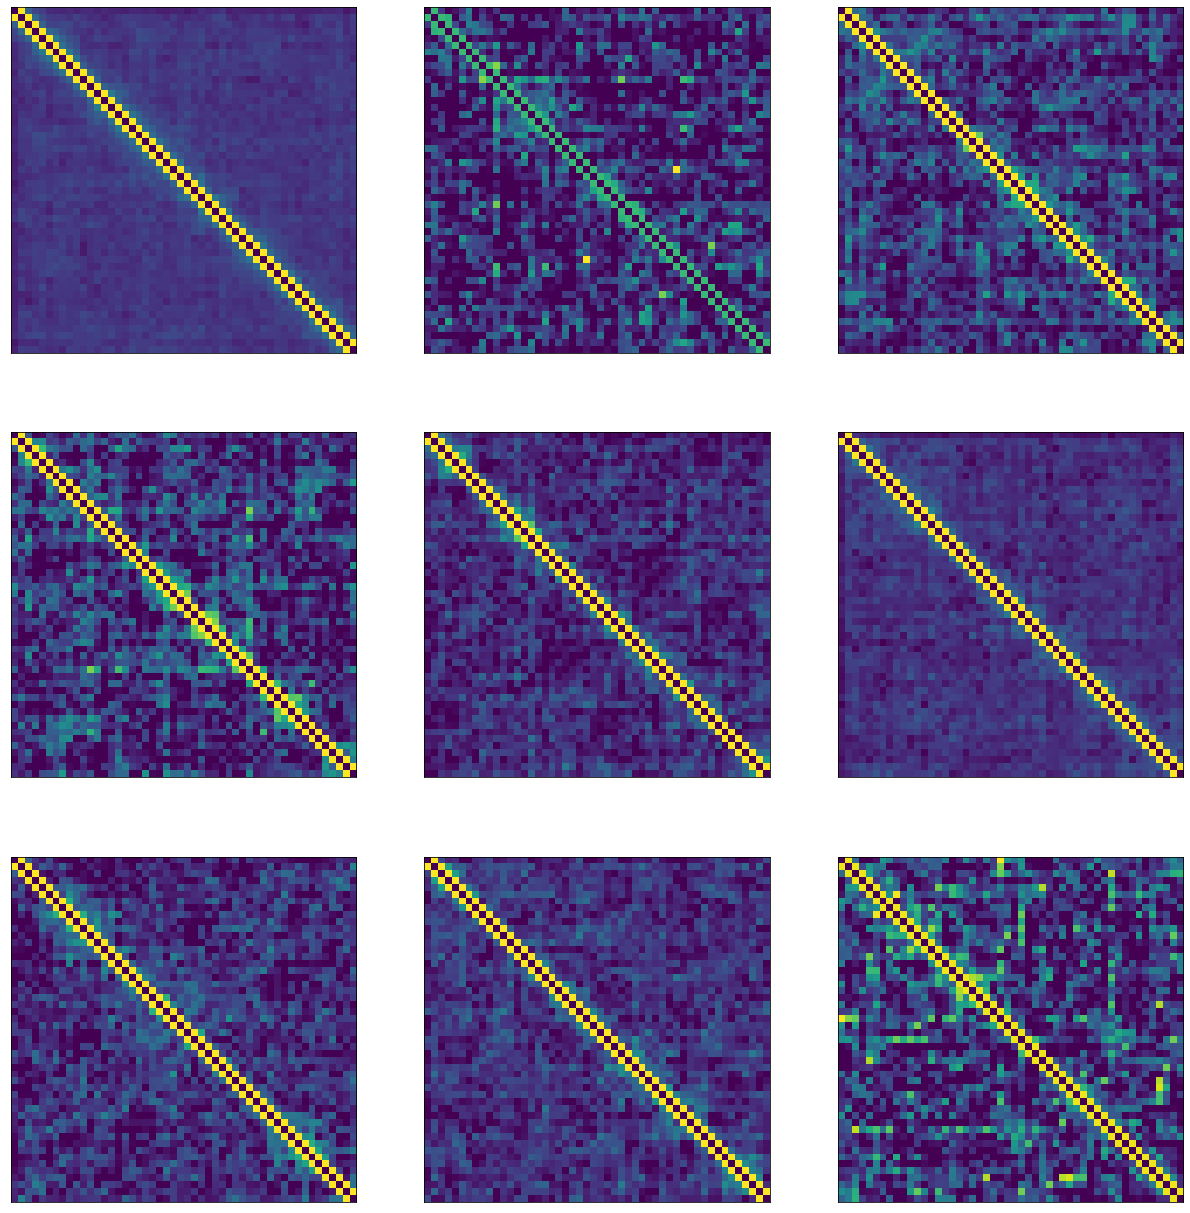

In [35]:
display_dictionary(W = W, figsize=[20,20])

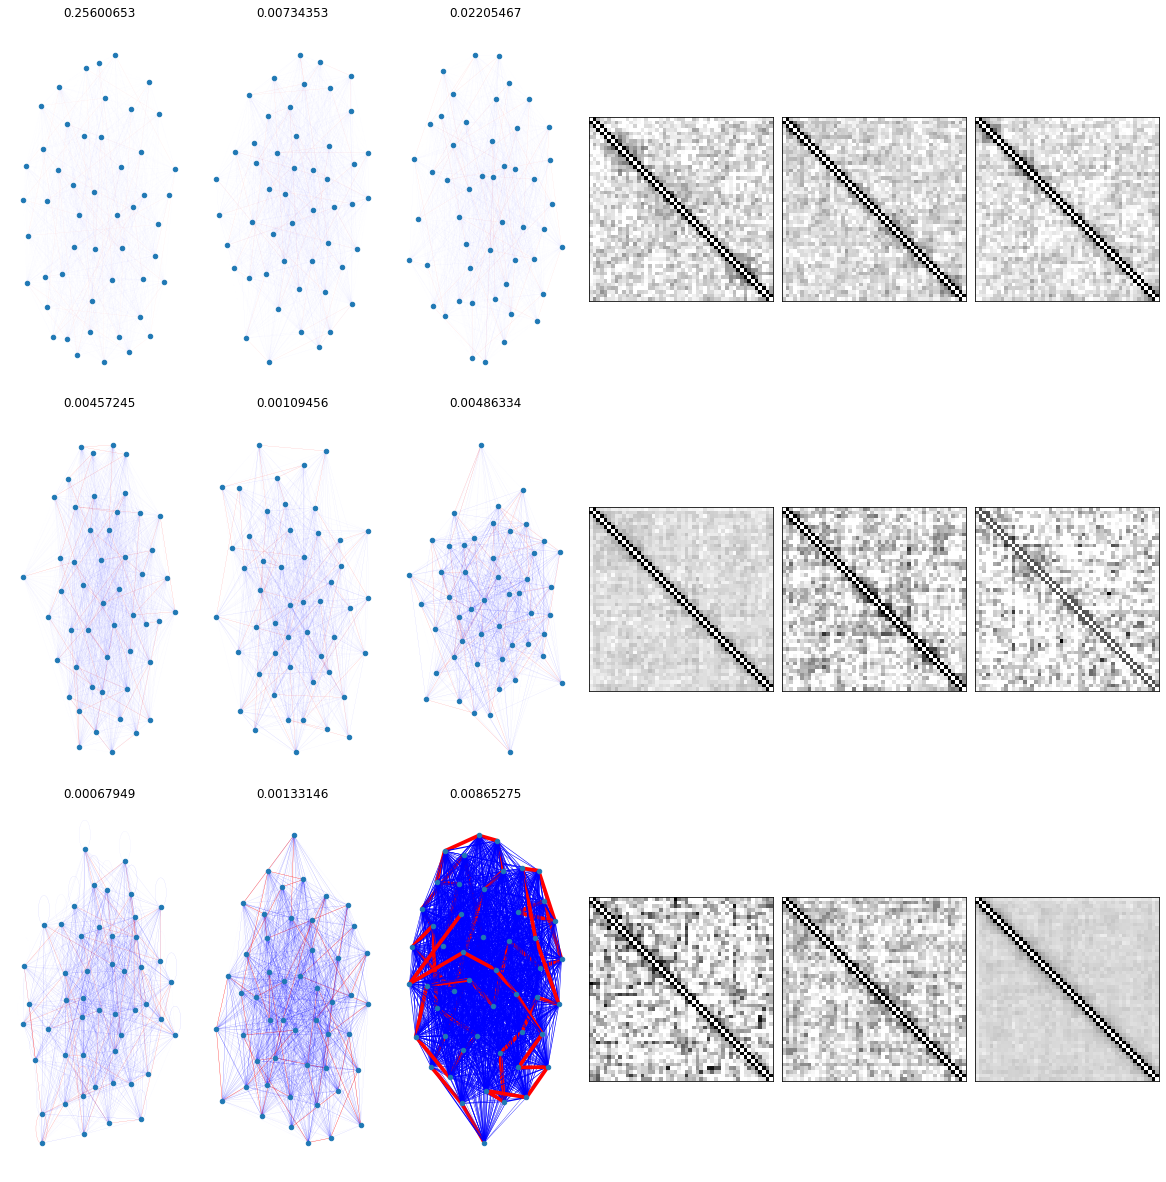

In [36]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 50, 
                       fig_size = [20,20], 
                       show_importance = False)

In [37]:
# SDL_BCD_filter
data_scale=10
results_dict_list_filter9 = []
iteration1 = 200
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class_filter9 = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                       X_test = [X_test.T/data_scale, Y_test.T],
                                       n_components = r,
                                       xi = xi,
                                       L1_reg = [0,0,0],
                                       L2_reg = [0,0,0],
                                       nonnegativity = [True,True,False],
                                       full_dim = False)

        results_dict_new_filter9 = SDL_BCD_class_filter9.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.67144592  0.0604713  -0.28390926 -0.01282915  0.88599389  0.46435135
   0.42240698 -0.3286141   0.38609615  0.6157467 ]]


  1%|▍                                          | 2/200 [00:00<00:31,  6.32it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 0: Training loss --- [Data, Label, Total] = [333.354063.3, 1249.087459.3, 1249.087459.3]


  6%|██▌                                       | 12/200 [00:01<00:30,  6.22it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.617]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.205063.3, 1249.017902.3, 1249.017902.3]


 11%|████▌                                     | 22/200 [00:03<00:25,  6.90it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.707]
--- Iteration 20: Training loss --- [Data, Label, Total] = [3.233511.3, 1248.650662.3, 1248.650662.3]


 16%|██████▋                                   | 32/200 [00:04<00:25,  6.50it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 30: Training loss --- [Data, Label, Total] = [3.344358.3, 1248.594352.3, 1248.594352.3]


 21%|████████▊                                 | 42/200 [00:05<00:22,  6.90it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 40: Training loss --- [Data, Label, Total] = [3.351321.3, 1248.593817.3, 1248.593817.3]


 26%|██████████▉                               | 52/200 [00:07<00:23,  6.34it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 50: Training loss --- [Data, Label, Total] = [3.351767.3, 1248.593821.3, 1248.593821.3]


 31%|█████████████                             | 62/200 [00:08<00:20,  6.59it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.351804.3, 1248.593822.3, 1248.593822.3]


 36%|███████████████                           | 72/200 [00:10<00:20,  6.38it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 70: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 41%|█████████████████▏                        | 82/200 [00:11<00:18,  6.27it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 80: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 46%|███████████████████▎                      | 92/200 [00:13<00:16,  6.74it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 90: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 51%|████████████████████▉                    | 102/200 [00:14<00:14,  6.71it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 56%|██████████████████████▉                  | 112/200 [00:16<00:13,  6.34it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 110: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 61%|█████████████████████████                | 122/200 [00:17<00:11,  6.82it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 120: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 66%|███████████████████████████              | 132/200 [00:19<00:11,  6.04it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 130: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 71%|█████████████████████████████            | 142/200 [00:20<00:09,  5.89it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 140: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 76%|███████████████████████████████▏         | 152/200 [00:22<00:07,  6.50it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 150: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 81%|█████████████████████████████████▏       | 162/200 [00:23<00:06,  5.65it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 160: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 86%|███████████████████████████████████▎     | 172/200 [00:25<00:04,  5.61it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 170: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:27<00:03,  5.75it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 180: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:28<00:01,  6.12it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 190: Training loss --- [Data, Label, Total] = [3.351807.3, 1248.593822.3, 1248.593822.3]


100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.66it/s]


!!! pred_type filter
initial loading beta [[ 0.30438275  0.24202906 -0.38168728 -0.29956959 -0.19213055  0.18889376
   0.3874737  -0.47391051  0.66077643 -0.92972496]]


  1%|▍                                          | 2/200 [00:00<00:34,  5.69it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [330.663177.3, 1249.085959.3, 1249.085959.3]


  6%|██▌                                       | 12/200 [00:01<00:31,  5.91it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.617]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.221797.3, 1249.017757.3, 1249.017757.3]


 11%|████▌                                     | 22/200 [00:03<00:30,  5.84it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.707]
--- Iteration 20: Training loss --- [Data, Label, Total] = [3.234679.3, 1248.652041.3, 1248.652041.3]


 16%|██████▋                                   | 32/200 [00:05<00:28,  5.86it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 30: Training loss --- [Data, Label, Total] = [3.344214.3, 1248.594371.3, 1248.594371.3]


 21%|████████▊                                 | 42/200 [00:06<00:27,  5.74it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 40: Training loss --- [Data, Label, Total] = [3.351307.3, 1248.593817.3, 1248.593817.3]


 26%|██████████▉                               | 52/200 [00:08<00:24,  6.16it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 50: Training loss --- [Data, Label, Total] = [3.351762.3, 1248.593821.3, 1248.593821.3]


 31%|█████████████                             | 62/200 [00:10<00:23,  5.83it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.351799.3, 1248.593822.3, 1248.593822.3]


 36%|███████████████                           | 72/200 [00:11<00:23,  5.55it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 70: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 41%|█████████████████▏                        | 82/200 [00:13<00:20,  5.75it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 80: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 46%|███████████████████▎                      | 92/200 [00:14<00:17,  6.21it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 90: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 51%|████████████████████▉                    | 102/200 [00:16<00:15,  6.30it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 56%|██████████████████████▉                  | 112/200 [00:18<00:14,  6.15it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 110: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 60%|████████████████████████▊                | 121/200 [00:19<00:13,  5.92it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 120: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 66%|███████████████████████████              | 132/200 [00:21<00:11,  5.90it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 130: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 71%|█████████████████████████████            | 142/200 [00:23<00:09,  6.08it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 140: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 76%|███████████████████████████████▏         | 152/200 [00:24<00:07,  6.09it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 150: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 81%|█████████████████████████████████▏       | 162/200 [00:26<00:06,  6.31it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 160: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 86%|███████████████████████████████████▎     | 172/200 [00:27<00:04,  5.83it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 170: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:29<00:02,  6.08it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 180: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:31<00:01,  5.81it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.732]
--- Iteration 190: Training loss --- [Data, Label, Total] = [3.351802.3, 1248.593822.3, 1248.593822.3]


100%|█████████████████████████████████████████| 200/200 [00:32<00:00,  6.18it/s]


!!! pred_type filter
initial loading beta [[ 0.77561036  0.87179272  0.20764664 -0.78683892  0.05683844 -0.20490739
  -0.55608466 -0.16112433  0.99715205  0.55514159]]


  1%|▍                                          | 2/200 [00:00<00:34,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 0: Training loss --- [Data, Label, Total] = [347.544131.3, 1249.092555.3, 1283.846969.3]


  6%|██▌                                       | 12/200 [00:02<00:32,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.609]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.142836.3, 1249.054848.3, 1249.369131.3]


 11%|████▌                                     | 22/200 [00:03<00:31,  5.61it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.672]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.759249.3, 1248.822686.3, 1249.098611.3]


 16%|██████▋                                   | 32/200 [00:05<00:28,  5.97it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.71]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.657595.3, 1248.661414.3, 1248.927173.3]


 21%|████████▊                                 | 42/200 [00:06<00:23,  6.68it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.721]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.510426.3, 1248.628902.3, 1248.879944.3]


 26%|██████████▉                               | 52/200 [00:08<00:22,  6.53it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.725]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.420575.3, 1248.619256.3, 1248.861314.3]


 31%|█████████████                             | 62/200 [00:09<00:20,  6.83it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.727]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.383582.3, 1248.614095.3, 1248.852453.3]


 36%|███████████████                           | 72/200 [00:11<00:20,  6.30it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.728]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.369769.3, 1248.610846.3, 1248.847823.3]


 41%|█████████████████▏                        | 82/200 [00:12<00:18,  6.37it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.363214.3, 1248.608698.3, 1248.845019.3]


 46%|███████████████████▎                      | 92/200 [00:14<00:16,  6.50it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.359160.3, 1248.607186.3, 1248.843102.3]


 51%|████████████████████▉                    | 102/200 [00:15<00:14,  6.54it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.356275.3, 1248.606056.3, 1248.841684.3]


 56%|██████████████████████▉                  | 112/200 [00:17<00:13,  6.35it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.354089.3, 1248.605173.3, 1248.840582.3]


 61%|█████████████████████████                | 122/200 [00:18<00:12,  6.36it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.352376.3, 1248.604458.3, 1248.839695.3]


 66%|███████████████████████████              | 132/200 [00:20<00:11,  6.16it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.351000.3, 1248.603863.3, 1248.838963.3]


 71%|█████████████████████████████            | 142/200 [00:21<00:10,  5.64it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.349873.3, 1248.603357.3, 1248.838344.3]


 76%|███████████████████████████████▏         | 152/200 [00:23<00:08,  5.69it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.348931.3, 1248.602921.3, 1248.837814.3]


 81%|█████████████████████████████████▏       | 162/200 [00:25<00:06,  5.76it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.348136.3, 1248.602538.3, 1248.837352.3]


 86%|███████████████████████████████████▎     | 172/200 [00:26<00:04,  5.93it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.347455.3, 1248.602200.3, 1248.836946.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:28<00:03,  5.77it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.346866.3, 1248.601898.3, 1248.836585.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:30<00:01,  5.47it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.346350.3, 1248.601626.3, 1248.836261.3]


100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.33it/s]


!!! pred_type filter
initial loading beta [[ 0.18985309 -0.88231265  0.18178647  0.07821353  0.38793955 -0.5094902
  -0.19865957  0.71438238  0.19183243 -0.17582772]]


  1%|▍                                          | 2/200 [00:00<00:38,  5.10it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [344.764752.3, 1249.091412.3, 1283.567887.3]


  6%|██▌                                       | 12/200 [00:02<00:34,  5.52it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.613]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.122176.3, 1249.045857.3, 1249.358075.3]


 11%|████▌                                     | 22/200 [00:03<00:32,  5.50it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.683]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.816291.3, 1248.776036.3, 1249.057665.3]


 16%|██████▋                                   | 32/200 [00:05<00:28,  5.89it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.716]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.713380.3, 1248.641025.3, 1248.912363.3]


 21%|████████▊                                 | 42/200 [00:07<00:30,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.724]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.518117.3, 1248.622516.3, 1248.874328.3]


 26%|██████████▋                               | 51/200 [00:09<00:29,  4.99it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.727]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.414919.3, 1248.616559.3, 1248.858051.3]


 31%|█████████████                             | 62/200 [00:11<00:24,  5.62it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.728]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.380238.3, 1248.612593.3, 1248.850616.3]


 36%|███████████████                           | 72/200 [00:12<00:21,  5.93it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.368408.3, 1248.609913.3, 1248.846754.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:19,  6.20it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.729]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.362674.3, 1248.608068.3, 1248.844335.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:17,  6.13it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.359006.3, 1248.606728.3, 1248.842628.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:16,  5.95it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.356343.3, 1248.605703.3, 1248.841338.3]


 56%|██████████████████████▉                  | 112/200 [00:19<00:13,  6.74it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.354301.3, 1248.604888.3, 1248.840318.3]


 61%|█████████████████████████                | 122/200 [00:20<00:14,  5.39it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.352686.3, 1248.604218.3, 1248.839487.3]


 66%|███████████████████████████              | 132/200 [00:22<00:11,  5.92it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.351383.3, 1248.603655.3, 1248.838794.3]


 71%|█████████████████████████████            | 142/200 [00:24<00:10,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.350312.3, 1248.603172.3, 1248.838204.3]


 76%|███████████████████████████████▏         | 152/200 [00:25<00:07,  6.38it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.73]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.349419.3, 1248.602753.3, 1248.837695.3]


 81%|█████████████████████████████████▏       | 162/200 [00:27<00:06,  6.32it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.348661.3, 1248.602384.3, 1248.837250.3]


 86%|███████████████████████████████████▎     | 172/200 [00:28<00:04,  6.26it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.348011.3, 1248.602055.3, 1248.836856.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:30<00:02,  6.00it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.347446.3, 1248.601761.3, 1248.836506.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:31<00:01,  6.09it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.731]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.346951.3, 1248.601496.3, 1248.836191.3]


100%|█████████████████████████████████████████| 200/200 [00:32<00:00,  6.07it/s]


!!! pred_type filter
initial loading beta [[-0.78292493 -0.81290881 -0.27090711  0.70068892 -0.28395912 -0.50069901
  -0.8523982   0.56441508 -0.86469738 -0.41659386]]


  1%|▍                                          | 2/200 [00:00<00:36,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [444.224442.3, 1249.127779.3, 1693.352220.3]


  6%|██▌                                       | 12/200 [00:01<00:30,  6.11it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.595]
--- Iteration 10: Training loss --- [Data, Label, Total] = [2.766755.3, 1249.149936.3, 1251.916691.3]


 11%|████▌                                     | 22/200 [00:03<00:31,  5.72it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.6]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.432733.3, 1249.142105.3, 1251.574838.3]


 16%|██████▋                                   | 32/200 [00:05<00:28,  5.91it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.605]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.386088.3, 1249.134227.3, 1251.520314.3]


 21%|████████▊                                 | 42/200 [00:06<00:25,  6.22it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.61]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.365977.3, 1249.125508.3, 1251.491485.3]


 26%|██████████▉                               | 52/200 [00:08<00:25,  5.82it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.616]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.354703.3, 1249.115696.3, 1251.470399.3]


 31%|█████████████                             | 62/200 [00:10<00:25,  5.47it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.621]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.347794.3, 1249.104664.3, 1251.452458.3]


 36%|███████████████                           | 72/200 [00:11<00:22,  5.67it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.626]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.343337.3, 1249.092322.3, 1251.435659.3]


 41%|█████████████████▏                        | 82/200 [00:13<00:21,  5.59it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.632]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.340338.3, 1249.078582.3, 1251.418920.3]


 46%|███████████████████▎                      | 92/200 [00:15<00:19,  5.54it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.638]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.338244.3, 1249.063433.3, 1251.401676.3]


 51%|████████████████████▉                    | 102/200 [00:16<00:15,  6.19it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.643]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.336734.3, 1249.046860.3, 1251.383594.3]


 56%|██████████████████████▉                  | 112/200 [00:18<00:14,  6.16it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.649]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.335615.3, 1249.028924.3, 1251.364539.3]


 61%|█████████████████████████                | 122/200 [00:19<00:13,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.654]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.334767.3, 1249.009688.3, 1251.344455.3]


 66%|███████████████████████████              | 132/200 [00:21<00:10,  6.28it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.659]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.334116.3, 1248.989296.3, 1251.323411.3]


 71%|█████████████████████████████            | 142/200 [00:23<00:09,  6.26it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.665]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.333608.3, 1248.967920.3, 1251.301528.3]


 76%|███████████████████████████████▏         | 152/200 [00:24<00:07,  6.71it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.669]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.333207.3, 1248.945792.3, 1251.279000.3]


 81%|█████████████████████████████████▏       | 162/200 [00:25<00:05,  6.53it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.674]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.332889.3, 1248.923172.3, 1251.256061.3]


 86%|███████████████████████████████████▎     | 172/200 [00:27<00:04,  5.75it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.678]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.332635.3, 1248.900335.3, 1251.232970.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:29<00:02,  6.26it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.683]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.332432.3, 1248.877555.3, 1251.209987.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:30<00:01,  6.15it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.687]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.332270.3, 1248.855016.3, 1251.187286.3]


100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.31it/s]


!!! pred_type filter
initial loading beta [[-0.10214083  0.97594654 -0.71561129  0.98433926 -0.06996992  0.08166119
   0.95893726  0.8298604  -0.5183109   0.75088704]]


  1%|▍                                          | 2/200 [00:00<00:33,  5.96it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [441.534493.3, 1249.128241.3, 1690.662734.3]


  6%|██▌                                       | 12/200 [00:01<00:29,  6.37it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.594]
--- Iteration 10: Training loss --- [Data, Label, Total] = [2.824960.3, 1249.149244.3, 1251.974204.3]


 11%|████▌                                     | 22/200 [00:03<00:28,  6.19it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.599]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.413634.3, 1249.139851.3, 1251.553485.3]


 16%|██████▋                                   | 32/200 [00:04<00:26,  6.36it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.605]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.371386.3, 1249.129894.3, 1251.501280.3]


 21%|████████▊                                 | 42/200 [00:06<00:25,  6.15it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.612]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.356885.3, 1249.118554.3, 1251.475438.3]


 26%|██████████▉                               | 52/200 [00:07<00:23,  6.37it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.618]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.349368.3, 1249.105574.3, 1251.454942.3]


 31%|█████████████                             | 62/200 [00:09<00:21,  6.48it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.624]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.344755.3, 1249.090825.3, 1251.435580.3]


 36%|███████████████                           | 72/200 [00:11<00:20,  6.22it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.631]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.341652.3, 1249.074203.3, 1251.415855.3]


 41%|█████████████████▏                        | 82/200 [00:12<00:19,  6.14it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.637]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.339429.3, 1249.055654.3, 1251.395082.3]


 46%|███████████████████▎                      | 92/200 [00:14<00:17,  6.22it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.644]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.337759.3, 1249.035221.3, 1251.372980.3]


 51%|████████████████████▉                    | 102/200 [00:15<00:15,  6.18it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.651]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.336459.3, 1249.013089.3, 1251.349548.3]


 56%|██████████████████████▉                  | 112/200 [00:17<00:15,  5.63it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.657]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.335426.3, 1248.989459.3, 1251.324885.3]


 61%|█████████████████████████                | 122/200 [00:18<00:13,  5.77it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.663]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.334588.3, 1248.964524.3, 1251.299112.3]


 66%|███████████████████████████              | 132/200 [00:20<00:12,  5.65it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.668]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.333901.3, 1248.938581.3, 1251.272482.3]


 71%|█████████████████████████████            | 142/200 [00:22<00:09,  6.04it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.673]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.333335.3, 1248.911998.3, 1251.245333.3]


 76%|███████████████████████████████▏         | 152/200 [00:23<00:07,  6.12it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.679]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.332865.3, 1248.885268.3, 1251.218133.3]


 81%|█████████████████████████████████▏       | 162/200 [00:25<00:06,  5.44it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.684]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.332470.3, 1248.858848.3, 1251.191318.3]


 86%|███████████████████████████████████▎     | 172/200 [00:27<00:05,  4.80it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.688]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.332136.3, 1248.833100.3, 1251.165237.3]


 90%|█████████████████████████████████████    | 181/200 [00:29<00:03,  5.24it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.692]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.331847.3, 1248.808526.3, 1251.140372.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:31<00:01,  5.42it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.696]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.331591.3, 1248.785515.3, 1251.117107.3]


100%|█████████████████████████████████████████| 200/200 [00:32<00:00,  6.13it/s]


!!! pred_type filter
initial loading beta [[-0.59793212  0.29289427  0.72894697 -0.44857294 -0.24914023 -0.25161993
  -0.42001926 -0.33669929 -0.98250339  0.42492165]]


  1%|▍                                          | 2/200 [00:00<00:33,  5.83it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.594]
--- Iteration 0: Training loss --- [Data, Label, Total] = [431.527302.3, 1249.180138.3, 3406.816649.3]


  6%|██▌                                       | 12/200 [00:01<00:28,  6.52it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.587]
--- Iteration 10: Training loss --- [Data, Label, Total] = [2.674765.3, 1249.183254.3, 1262.557078.3]


 11%|████▌                                     | 22/200 [00:03<00:28,  6.35it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.588]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.398348.3, 1249.182777.3, 1261.174518.3]


 16%|██████▋                                   | 32/200 [00:04<00:26,  6.30it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.588]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.377592.3, 1249.182350.3, 1261.070308.3]


 21%|████████▊                                 | 42/200 [00:06<00:24,  6.52it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.589]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.369835.3, 1249.181936.3, 1261.031112.3]


 26%|██████████▉                               | 52/200 [00:07<00:22,  6.67it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.59]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.365250.3, 1249.181526.3, 1261.007774.3]


 31%|█████████████                             | 62/200 [00:09<00:21,  6.40it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.59]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.361712.3, 1249.181117.3, 1260.989677.3]


 36%|███████████████                           | 72/200 [00:10<00:20,  6.31it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.591]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.358659.3, 1249.180710.3, 1260.974007.3]


 41%|█████████████████▏                        | 82/200 [00:12<00:18,  6.47it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.355930.3, 1249.180302.3, 1260.959953.3]


 46%|███████████████████▎                      | 92/200 [00:13<00:17,  6.34it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.353472.3, 1249.179894.3, 1260.947254.3]


 51%|████████████████████▉                    | 102/200 [00:15<00:15,  6.14it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.351260.3, 1249.179486.3, 1260.935787.3]


 56%|██████████████████████▉                  | 112/200 [00:16<00:13,  6.51it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.594]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.349279.3, 1249.179077.3, 1260.925474.3]


 61%|█████████████████████████                | 122/200 [00:18<00:12,  6.06it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.594]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.347515.3, 1249.178667.3, 1260.916242.3]


 66%|███████████████████████████              | 132/200 [00:20<00:11,  6.10it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.595]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.345952.3, 1249.178255.3, 1260.908013.3]


 71%|█████████████████████████████            | 142/200 [00:21<00:09,  6.10it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.596]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.344571.3, 1249.177841.3, 1260.900697.3]


 76%|███████████████████████████████▏         | 152/200 [00:23<00:08,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.596]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.343356.3, 1249.177425.3, 1260.894207.3]


 81%|█████████████████████████████████▏       | 162/200 [00:25<00:06,  5.94it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.597]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.342291.3, 1249.177006.3, 1260.888462.3]


 86%|███████████████████████████████████▎     | 172/200 [00:26<00:04,  6.13it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.597]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.341359.3, 1249.176584.3, 1260.883381.3]


 90%|█████████████████████████████████████    | 181/200 [00:28<00:03,  5.46it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.598]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.340545.3, 1249.176158.3, 1260.878886.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:30<00:01,  5.61it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.599]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.339836.3, 1249.175728.3, 1260.874907.3]


100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.37it/s]


!!! pred_type filter
initial loading beta [[-0.94904062  0.09975006  0.84087244 -0.13172922 -0.48625757  0.92805733
   0.88675335  0.65400087 -0.62882007 -0.18752767]]


  1%|▍                                          | 2/200 [00:00<00:39,  5.01it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.59]
--- Iteration 0: Training loss --- [Data, Label, Total] = [434.448796.3, 1249.181648.3, 3421.425627.3]


  6%|██▌                                       | 12/200 [00:02<00:32,  5.85it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.59]
--- Iteration 10: Training loss --- [Data, Label, Total] = [2.541634.3, 1249.181839.3, 1261.890007.3]


 11%|████▌                                     | 22/200 [00:03<00:32,  5.51it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.591]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2.382903.3, 1249.181347.3, 1261.095862.3]


 16%|██████▋                                   | 32/200 [00:05<00:26,  6.27it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.375699.3, 1249.180889.3, 1261.059384.3]


 21%|████████▊                                 | 42/200 [00:06<00:24,  6.40it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.592]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.372799.3, 1249.180433.3, 1261.044426.3]


 26%|██████████▉                               | 52/200 [00:08<00:24,  5.98it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.593]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.370405.3, 1249.179977.3, 1261.032003.3]


 31%|█████████████                             | 62/200 [00:09<00:21,  6.36it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.594]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.368217.3, 1249.179519.3, 1261.020605.3]


 36%|███████████████                           | 72/200 [00:11<00:20,  6.21it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.594]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.366179.3, 1249.179059.3, 1261.009953.3]


 41%|█████████████████▏                        | 82/200 [00:12<00:18,  6.39it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.595]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.364271.3, 1249.178594.3, 1260.999949.3]


 46%|███████████████████▎                      | 92/200 [00:14<00:17,  6.07it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.596]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.362482.3, 1249.178127.3, 1260.990538.3]


 51%|████████████████████▉                    | 102/200 [00:15<00:15,  6.49it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.596]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.360803.3, 1249.177655.3, 1260.981671.3]


 56%|██████████████████████▉                  | 112/200 [00:17<00:13,  6.43it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.597]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.359226.3, 1249.177180.3, 1260.973310.3]


 61%|█████████████████████████                | 122/200 [00:19<00:12,  6.01it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.598]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.357744.3, 1249.176701.3, 1260.965420.3]


 66%|███████████████████████████              | 132/200 [00:20<00:11,  5.91it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.599]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.356351.3, 1249.176217.3, 1260.957970.3]


 71%|█████████████████████████████            | 142/200 [00:22<00:09,  6.19it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.599]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.355041.3, 1249.175729.3, 1260.950936.3]


 76%|███████████████████████████████▏         | 152/200 [00:23<00:07,  6.16it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.6]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.353811.3, 1249.175236.3, 1260.944291.3]


 81%|█████████████████████████████████▏       | 162/200 [00:25<00:05,  6.35it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.6]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.352655.3, 1249.174738.3, 1260.938011.3]


 86%|███████████████████████████████████▎     | 172/200 [00:26<00:04,  5.73it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.601]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.351568.3, 1249.174234.3, 1260.932075.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:28<00:02,  6.07it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.602]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.350547.3, 1249.173726.3, 1260.926459.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:30<00:01,  5.51it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.602]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.349586.3, 1249.173212.3, 1260.921144.3]


100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.35it/s]


!!! pred_type filter
initial loading beta [[ 0.49037017 -0.16998244  0.37659367 -0.15610063  0.4444652   0.59824766
  -0.30916898 -0.50301838 -0.70099085  0.28857426]]


  1%|▍                                          | 2/200 [00:00<00:35,  5.62it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.541]
--- Iteration 0: Training loss --- [Data, Label, Total] = [365.971359.3, 1249.199732.3, 4908.913327.3]


  6%|██▌                                       | 12/200 [00:02<00:32,  5.84it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.571770.3, 1249.199729.3, 1284.917425.3]


 11%|████▌                                     | 22/200 [00:03<00:28,  6.17it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 20: Training loss --- [Data, Label, Total] = [3.566594.3, 1249.199729.3, 1284.865671.3]


 16%|██████▋                                   | 32/200 [00:05<00:26,  6.25it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 30: Training loss --- [Data, Label, Total] = [3.564713.3, 1249.199729.3, 1284.846855.3]


 21%|████████▊                                 | 42/200 [00:06<00:26,  6.07it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 40: Training loss --- [Data, Label, Total] = [3.562135.3, 1249.199729.3, 1284.821082.3]


 26%|██████████▉                               | 52/200 [00:08<00:22,  6.44it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 50: Training loss --- [Data, Label, Total] = [3.558701.3, 1249.199729.3, 1284.786742.3]


 31%|█████████████                             | 62/200 [00:09<00:19,  6.97it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.554238.3, 1249.199729.3, 1284.742111.3]


 36%|███████████████                           | 72/200 [00:11<00:19,  6.69it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 70: Training loss --- [Data, Label, Total] = [3.547355.3, 1249.199729.3, 1284.673275.3]


 41%|█████████████████▏                        | 82/200 [00:12<00:19,  6.02it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 80: Training loss --- [Data, Label, Total] = [3.537534.3, 1249.199729.3, 1284.575073.3]


 46%|███████████████████▎                      | 92/200 [00:14<00:20,  5.35it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 90: Training loss --- [Data, Label, Total] = [3.522535.3, 1249.199729.3, 1284.425077.3]


 51%|████████████████████▉                    | 102/200 [00:16<00:15,  6.42it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3.501952.3, 1249.199729.3, 1284.219244.3]


 56%|██████████████████████▉                  | 112/200 [00:17<00:14,  6.15it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 110: Training loss --- [Data, Label, Total] = [3.473691.3, 1249.199729.3, 1283.936644.3]


 61%|█████████████████████████                | 122/200 [00:19<00:11,  6.58it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 120: Training loss --- [Data, Label, Total] = [3.437428.3, 1249.199729.3, 1283.574008.3]


 66%|███████████████████████████              | 132/200 [00:20<00:10,  6.58it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.538]
--- Iteration 130: Training loss --- [Data, Label, Total] = [3.396138.3, 1249.199729.3, 1283.161105.3]


 71%|█████████████████████████████            | 142/200 [00:22<00:08,  6.73it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.539]
--- Iteration 140: Training loss --- [Data, Label, Total] = [3.350610.3, 1249.199729.3, 1282.705833.3]


 76%|███████████████████████████████▏         | 152/200 [00:23<00:08,  5.51it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.539]
--- Iteration 150: Training loss --- [Data, Label, Total] = [3.303596.3, 1249.199729.3, 1282.235689.3]


 81%|█████████████████████████████████▏       | 162/200 [00:25<00:06,  6.24it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.539]
--- Iteration 160: Training loss --- [Data, Label, Total] = [3.254876.3, 1249.199728.3, 1281.748493.3]


 86%|███████████████████████████████████▎     | 172/200 [00:26<00:04,  6.17it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.539]
--- Iteration 170: Training loss --- [Data, Label, Total] = [3.204568.3, 1249.199728.3, 1281.245403.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:28<00:03,  5.43it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.539]
--- Iteration 180: Training loss --- [Data, Label, Total] = [3.152819.3, 1249.199728.3, 1280.727920.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:30<00:01,  6.14it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.539]
--- Iteration 190: Training loss --- [Data, Label, Total] = [3.099157.3, 1249.199728.3, 1280.191301.3]


100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.43it/s]


!!! pred_type filter
initial loading beta [[-0.07246543  0.71481295  0.76852176  0.31463408  0.00182824  0.61498264
   0.42939532  0.24199171  0.0761607  -0.51578386]]


  1%|▍                                          | 2/200 [00:00<00:32,  6.16it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.566]
--- Iteration 0: Training loss --- [Data, Label, Total] = [370.453657.3, 1249.199727.3, 4953.736298.3]


  6%|██▌                                       | 12/200 [00:01<00:28,  6.71it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.523]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.579889.3, 1249.199736.3, 1284.998628.3]


 11%|████▌                                     | 22/200 [00:03<00:32,  5.53it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.522]
--- Iteration 20: Training loss --- [Data, Label, Total] = [3.553352.3, 1249.199736.3, 1284.733253.3]


 16%|██████▋                                   | 32/200 [00:05<00:30,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.522]
--- Iteration 30: Training loss --- [Data, Label, Total] = [3.550682.3, 1249.199736.3, 1284.706555.3]


 21%|████████▊                                 | 42/200 [00:06<00:22,  7.00it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.522]
--- Iteration 40: Training loss --- [Data, Label, Total] = [3.546180.3, 1249.199736.3, 1284.661535.3]


 26%|██████████▉                               | 52/200 [00:08<00:23,  6.25it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.522]
--- Iteration 50: Training loss --- [Data, Label, Total] = [3.537153.3, 1249.199736.3, 1284.571262.3]


 31%|█████████████                             | 62/200 [00:09<00:21,  6.49it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.522]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.524079.3, 1249.199736.3, 1284.440525.3]


 36%|███████████████                           | 72/200 [00:11<00:21,  6.00it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.522]
--- Iteration 70: Training loss --- [Data, Label, Total] = [3.508831.3, 1249.199736.3, 1284.288050.3]


 41%|█████████████████▏                        | 82/200 [00:12<00:18,  6.41it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.523]
--- Iteration 80: Training loss --- [Data, Label, Total] = [3.484466.3, 1249.199736.3, 1284.044400.3]


 46%|███████████████████▎                      | 92/200 [00:14<00:16,  6.70it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.523]
--- Iteration 90: Training loss --- [Data, Label, Total] = [3.446831.3, 1249.199736.3, 1283.668051.3]


 51%|████████████████████▉                    | 102/200 [00:15<00:14,  6.74it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.523]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3.404511.3, 1249.199736.3, 1283.244845.3]


 56%|██████████████████████▉                  | 112/200 [00:17<00:12,  6.78it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.523]
--- Iteration 110: Training loss --- [Data, Label, Total] = [3.360491.3, 1249.199736.3, 1282.804644.3]


 60%|████████████████████████▊                | 121/200 [00:18<00:14,  5.63it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.523]
--- Iteration 120: Training loss --- [Data, Label, Total] = [3.306723.3, 1249.199736.3, 1282.266966.3]


 66%|███████████████████████████              | 132/200 [00:20<00:11,  5.80it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.523]
--- Iteration 130: Training loss --- [Data, Label, Total] = [3.245270.3, 1249.199736.3, 1281.652436.3]


 71%|█████████████████████████████            | 142/200 [00:22<00:08,  6.65it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.524]
--- Iteration 140: Training loss --- [Data, Label, Total] = [3.181792.3, 1249.199736.3, 1281.017652.3]


 76%|███████████████████████████████▏         | 152/200 [00:23<00:08,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.524]
--- Iteration 150: Training loss --- [Data, Label, Total] = [3.118607.3, 1249.199735.3, 1280.385809.3]


 81%|█████████████████████████████████▏       | 162/200 [00:25<00:05,  6.65it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.524]
--- Iteration 160: Training loss --- [Data, Label, Total] = [3.057061.3, 1249.199735.3, 1279.770342.3]


 86%|███████████████████████████████████▎     | 172/200 [00:26<00:04,  6.35it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.525]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.998601.3, 1249.199735.3, 1279.185749.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:28<00:02,  6.24it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.526]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.939192.3, 1249.199735.3, 1278.591650.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:29<00:01,  6.79it/s]

--- Training --- [threshold, AUC] =  [0.615, 0.526]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.881286.3, 1249.199734.3, 1278.012594.3]


100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.48it/s]


!!! pred_type filter


In [38]:
W = results_dict_new_filter9['loading'][0]
coeff = results_dict_new_filter9['loading'][1][0]
H = results_dict_new_filter9['code']

In [39]:
coeff

array([4.70355904e-01, 2.27068572e-04, 2.07765177e-04, 2.13139255e-04,
       5.08633864e-04, 2.38496755e-04, 2.12327942e-04, 2.11231106e-04,
       3.09381312e-04, 2.19986450e-04])

In [40]:
print('Accuracy: {}'.format(results_dict_new_filter9['Accuracy']))
print('Training RRE: {}'.format(results_dict_new_filter9['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new_filter9['Relative_reconstruction_loss (test)']))

Accuracy: 0.6032
Training RRE: 0.8058711580563458
Testing RRE: 0.8559314721784005


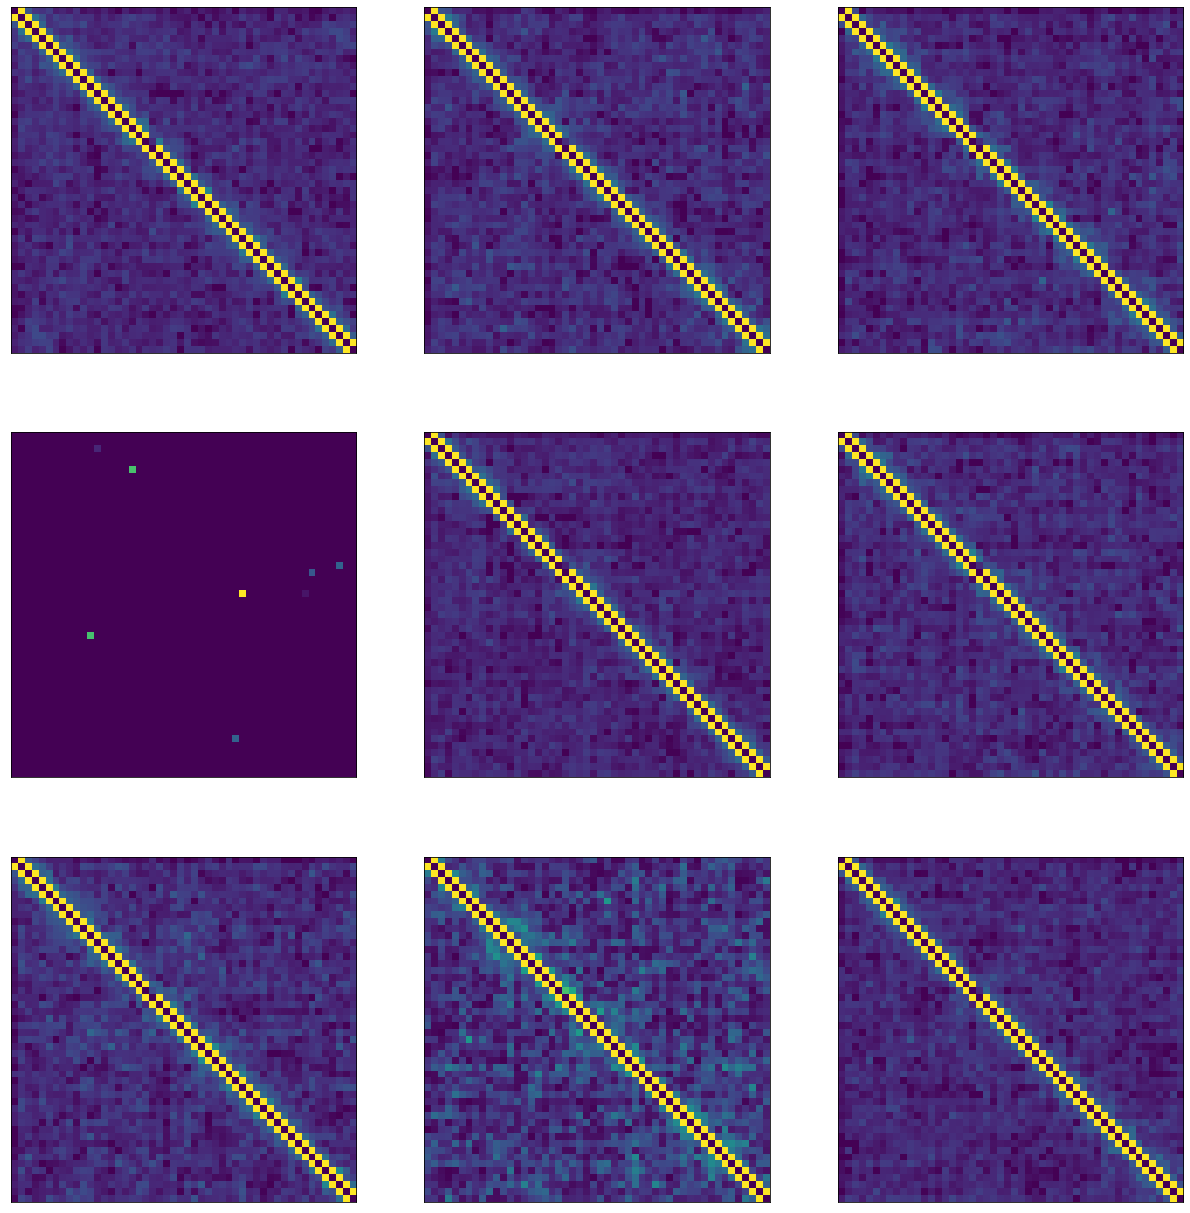

In [41]:
display_dictionary(W = W, figsize=[20,20])

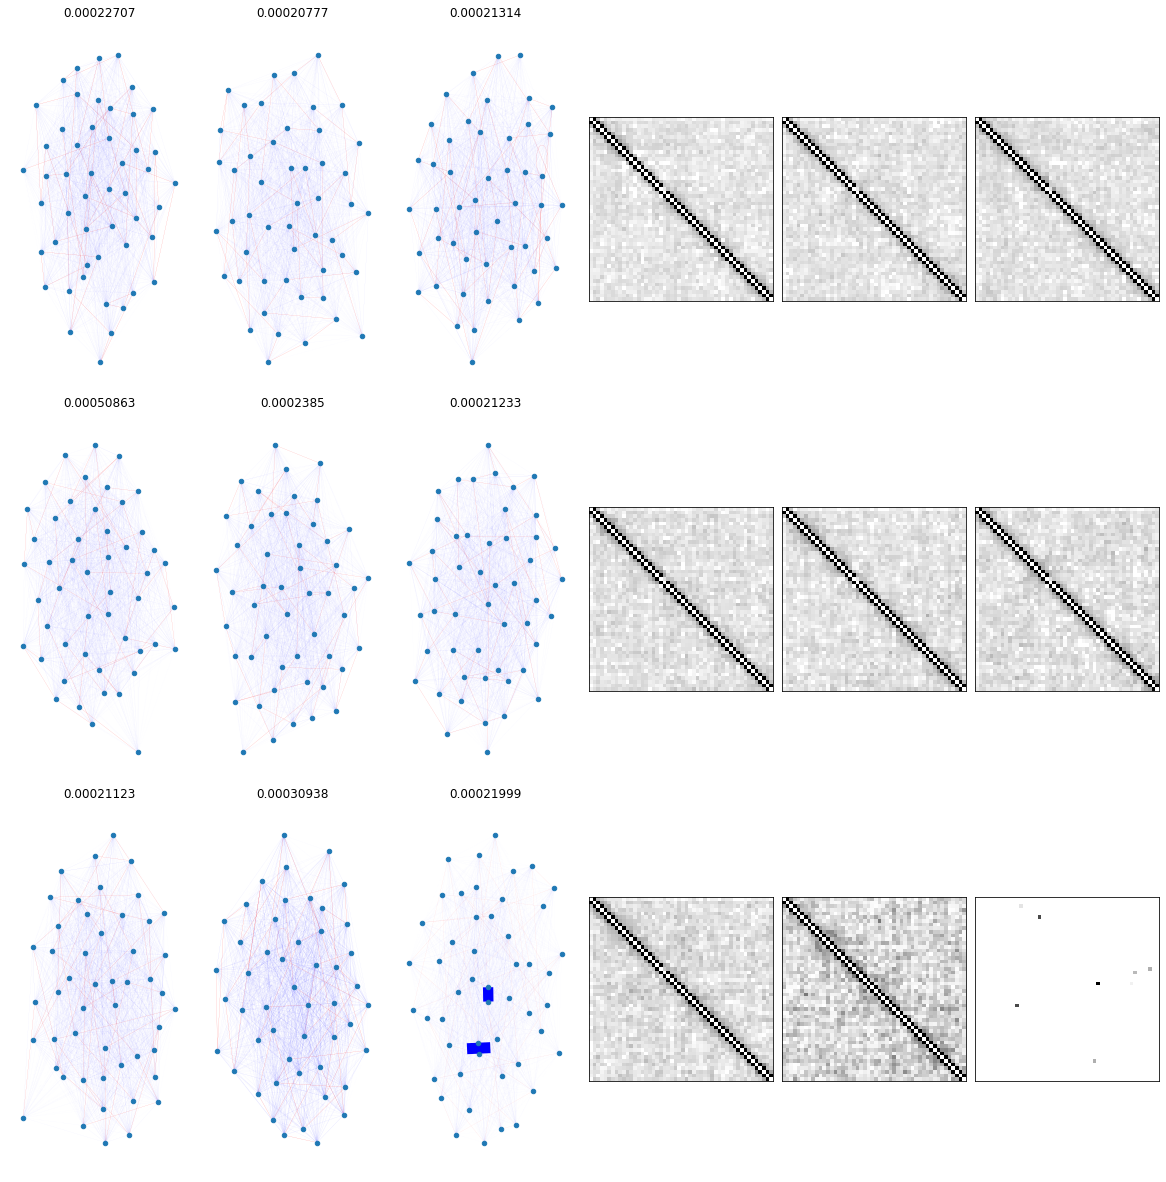

In [42]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 50, 
                       fig_size = [20,20], 
                       show_importance = False)